<div align="center"> 

---

# **Behavioral metrics**

</div>


---

<div align="center"> 

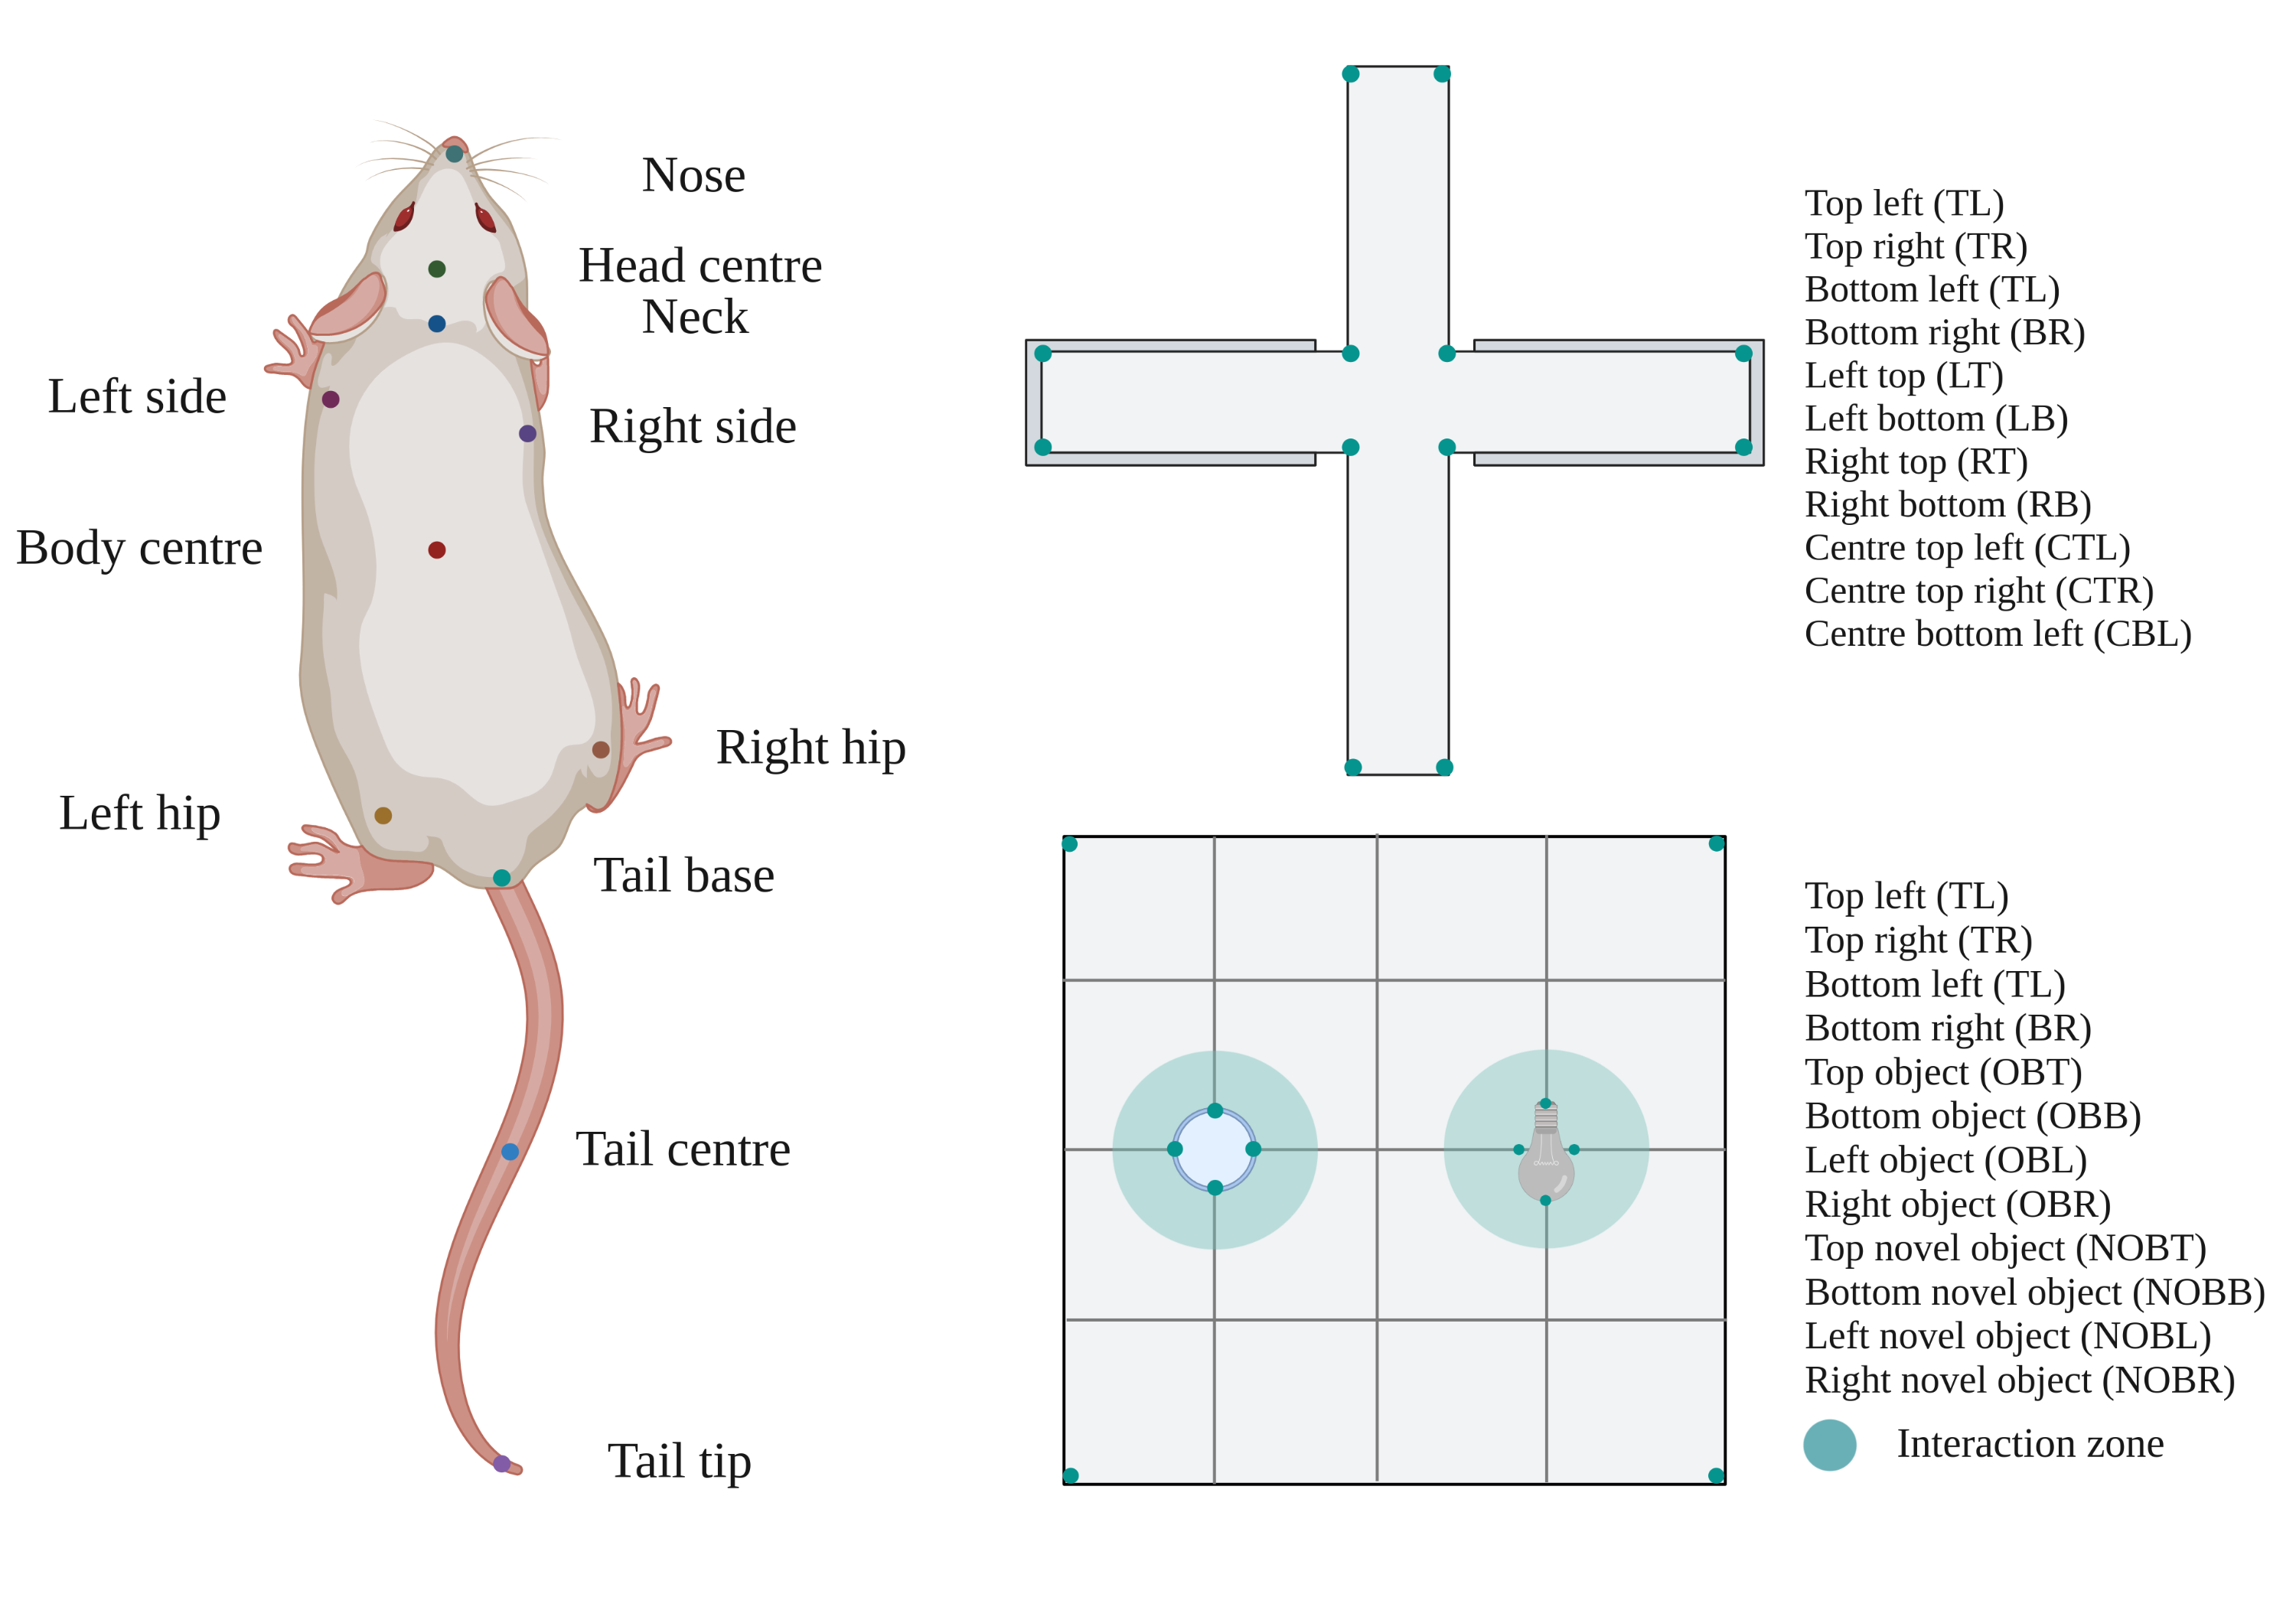

</div>

---
# <u> **Description:**</u>

Behavioral

---

## **Workflow**

0. Deeplabcut code
1. General preparation
2. Data preparation
3. Analysis
4. Exploratory data analysis
5. Visualization
6. Export data

---

**Variables to consider:** 
  - Session
  - Sex  
  
**Tasks:**
  - Elevated plus maze
  - Novel object recognition
  
**Analysis:**
  - 
  - 

---

### **General settings options**

In [1]:
addTaskCallback(function(...) {set.seed(42);TRUE})
options(warn=-1) # to turn off warnings
#options(warn=0) # to turn on warnings
options(repr.plot.width=14, repr.plot.height=10) # to resize plots

1 
1

In [2]:
setwd("/mnt/g/Other computers/My Laptop/PhD/Psilantro/Sudmex_alcohol_stress/")
load("Data/Alcohol_consumption.RData")

## **0. Deeplabcut code**

The raw and labelled videos can be found in:


We trained a neural network for each behavioral task, the code for running it into a HCP cluster and the options for it are:
  
[bash script](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLC/run_dlc.sh)   
[dlc commands](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLC/dlc_commands.py)

We created a neural network using the following bodyparts/maze labels:
- tl = top left
- tr = top right
- bl = bottom left
- br = bottom right
- obt = object top
- obb = object bottom
- obl = object left
- obr = object right
- nobt = novel object top
- nobb = novel object bottom
- nobl = novel object left
- nobr = novel object right
- nose
- headcentre
- neck
- bodycentre
- bcl = bodycentre left
- bcr = bodycentre right
- hipl = left hip
- hipr = right hip
- tailbase
- tailcentre
- tailtip

Config files to train the networks:
[Config EPM](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLC/config_EPM.yaml)   
[Config NOR](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLC/config_NOR.yaml) 

1. Once we trained the net, we tested for automatic tracking of each rat on each behavioral task
2. We exported the tracking to csv files
3. Using DLCAnalyzer we extracted the metrics of interest (https://www.nature.com/articles/s41386-020-0776-y)
    - EPM: Using the scripts (https://github.com/ETHZ-INS/DLCAnalyzer)
    - NOR: a modified script of DLC [script](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLC/DLCAnalyzer_NOR.R)

## **1. General preparation**

### **1.1 Load  R packages and dependencies.** 

  The following packages are needed for the to move on, firstly it is needed to download pacman library

 ---

In [3]:
# Make sure to install pacman before we begin
  if (!require("pacman")) {
  install.packages("pacman")
  }

# Load required packages  
  pacman::p_load(tidyverse,readxl,Matrix,lme4,devtools,ggpubr,rstatix,ggdist,sp,imputeTS,ggmap,data.table,
    cowplot,corrplot,keras,magrittr,gghalves,skimr,emmeans,multcomp,easystats)


Loading required package: pacman



Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


skimr installed

also installing the dependencies ‘TH.data’, ‘sandwich’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


multcomp installed



In [4]:
# Run DLCAnalyzer scripts
source("code/DLC/DLCAnalyzer_NOR.R")

In [5]:
pal_batch <- c("#264653","#2a9d8f","#5e548e","#ff595e","#03045e")

### **1.1 Files**

For EPM, the files are: 

- EPM: T1 and T2: {Batch}_EPM_{RID}_{Time}DLC_resnet50_EPMMar18shuffle1_{train_cycle}

For NOR, the files are:
- NOR: T1 and T2: {Batch}_{RID}_{Phase}DLC_resnet50_ORApr27shuffle1_{train_cycle}

---

---

# **Elevated plus maze**

---

## **2. Data preparation**

Reading files and set it all up.

Firstly, run the functions made by Sturman et al, (2020) and the modified function for NOR, the script is in:

[script](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLCAnalyzer_NOR.R)

Secondly, create the function to read, calibrating and analysis of the tracking accordingly with each batch recording (camera parameters)

Frames per second (fps):
- Batch 1: 7.5 and 22.5
- Batch 2: 7.5
- Batch 3: 30
- Batch 4: 15
- Batch 5: 15

#### Important: 

The bodycenter is the point-label to consider if the rat is in which arm

In [6]:
DBM_dataset <- read_csv("Data/DBM_dataset.csv")

Rows: 351 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): RID, Session, Subject, Group, Batch, Sex, IN
dbl (1): Age

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
T1_input_folder <- paste0(getwd(),"/Data/Behavior/EPM/T1/")
T2_input_folder <- paste0(getwd(),"/Data/Behavior/EPM/T2/")
RID_group <- DBM_dataset %>% dplyr::select("RID","Group","Sex","Batch") %>% unique() %>% 
            mutate(RID = if_else(as.numeric(str_split(RID,n = 2, pattern = "-") %>% 
                                    map_chr(~ .x %>% extract(2))) <= 100,
                                        paste0("sub-0",str_split(RID,n = 2, pattern = "-") %>% 
                                    map_chr(~ .x %>% extract(2))),
                                        paste0("sub-",str_split(RID,n = 2, pattern = "-") %>% 
                                    map_chr(~ .x %>% extract(2)))) )

DLCmetrics_selection <- c('file','bodycentre.distance.moving', 'bodycentre.speed.moving', 'bodycentre.time.moving', 'bodycentre.total.time', 
'nose.time.stationary', 'bodycentre.center.distance.moving', 'bodycentre.center.speed.moving',
'bodycentre.center.time.moving', 'bodycentre.center.total.time', 'bodycentre.center.time.stationary',
'bodycentre.center.transitions', 'bodycentre.open.distance.moving', 'bodycentre.open.speed.moving',
'bodycentre.open.time.moving', 'bodycentre.open.total.time', 'bodycentre.open.time.stationary',
'bodycentre.open.transitions', 'bodycentre.closed.distance.moving', 'bodycentre.closed.speed.moving',
'bodycentre.closed.time.moving', 'bodycentre.closed.total.time', 'bodycentre.closed.time.stationary',
'bodycentre.closed.transitions')

### **2.1 Create functions accordingly with each batch**

#### **2.1.1 Cut the duration of the videos**

In [8]:
bodypart_point <- "bodycentre"
# Create functions ---------------------------------------------------------
pipeline_1 <- function(path){
  Tracking <- ReadDLCDataFromCSV(file = path, fps = 22.5)
  Tracking <- CutTrackingData(Tracking,start = 100, end = 250)
  Tracking <- CalibrateTrackingData(Tracking, method = "distance",in.metric = 65.5, points = c("tl","br"))
  zoneinfo <- read.table(paste0(getwd(),"/code/DLC/EPM_zoneinfo.csv"), sep = ",", header = T)
  Tracking <- AddZones(Tracking,zoneinfo)
  Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.8))
  Tracking <- EPMAnalysis(Tracking, movement_cutoff = 5,integration_period = 5,points = bodypart_point, nosedips = TRUE)
  return(Tracking)
}

pipeline_2 <- function(path){
  Tracking <- ReadDLCDataFromCSV(file = path, fps = 7.5)
  Tracking <- CutTrackingData(Tracking,start = 100, end = 250)
  Tracking <- CalibrateTrackingData(Tracking, method = "distance",in.metric = 65.5, points = c("tl","br"))
  zoneinfo <- read.table(paste0(getwd(),"/code/DLC/EPM_zoneinfo.csv"), sep = ",", header = T)
  Tracking <- AddZones(Tracking,zoneinfo)
  Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.8))
  Tracking <- EPMAnalysis(Tracking, movement_cutoff = 5,integration_period = 5,points = bodypart_point, nosedips = TRUE)
  return(Tracking)
}

pipeline_3 <- function(path){
  Tracking <- ReadDLCDataFromCSV(file = path, fps = 30)
  Tracking <- CutTrackingData(Tracking,start = 100, end = 250)
  Tracking <- CalibrateTrackingData(Tracking, method = "distance",in.metric = 65.5, points = c("tl","br"))
  zoneinfo <- read.table(paste0(getwd(),"/code/DLC/EPM_zoneinfo.csv"), sep = ",", header = T)
  Tracking <- AddZones(Tracking,zoneinfo)
  Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.8))
  Tracking <- EPMAnalysis(Tracking, movement_cutoff = 5,integration_period = 5,points = bodypart_point, nosedips = TRUE)
  return(Tracking)
}

pipeline_45678 <- function(path){
  Tracking <- ReadDLCDataFromCSV(file = path, fps = 15)
  Tracking <- CutTrackingData(Tracking,start = 100, end = 250)
  Tracking <- CalibrateTrackingData(Tracking, method = "distance",in.metric = 65.5, points = c("tl","br"))
  zoneinfo <- read.table(paste0(getwd(),"/code/DLC/EPM_zoneinfo.csv"), sep = ",", header = T)
  Tracking <- AddZones(Tracking,zoneinfo)
  Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.8))
  Tracking <- EPMAnalysis(Tracking, movement_cutoff = 5,integration_period = 5,points = bodypart_point, nosedips = TRUE)
  return(Tracking)
}

### **2.2 Analyze tracking with DLC analyzer**

In [9]:
# Batch 1

### T1 ###
# No recorded

### T2 ###

B1_files_T2 <- list.files(T2_input_folder, pattern = "G1", recursive = T)[-c(7,12)]

B1_TrackingAll_T2 <- RunPipeline(B1_files_T2,T2_input_folder,FUN = pipeline_2)
B15_Report_T2 <- MultiFileReport(B1_TrackingAll_T2) #%>% dplyr::select(all_of(DLCmetrics_selection))


# Batch 1.1

### T2 ###
B17_files_T2 <- list.files(T2_input_folder, pattern = "G1_EPM_07") 
B17_TrackingAll_T2 <- RunPipeline(B17_files_T2,T2_input_folder,FUN = pipeline_1)
B17_Report_T2 <- MultiFileReport(B17_TrackingAll_T2) #%>% dplyr::select(all_of(DLCmetrics_selection))

B114_files_T2 <- list.files(T2_input_folder, pattern = "G1_EPM_14") 
B114_TrackingAll_T2 <- RunPipeline(B114_files_T2,T2_input_folder,FUN = pipeline_1)
B114_Report_T2 <- MultiFileReport(B114_TrackingAll_T2) #%>% dplyr::select(all_of(DLCmetrics_selection))

B1_Report_T2 <- rbind.data.frame(B15_Report_T2,B17_Report_T2,B114_Report_T2)

[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"


In [10]:
# Batch 2

### T1 ###

B2_files_T1 <- list.files(T1_input_folder, pattern = "G2", recursive = T)

B2_TrackingAll_T1 <- RunPipeline(B2_files_T1,T1_input_folder,FUN = pipeline_2)
B2_Report_T1 <- MultiFileReport(B2_TrackingAll_T1) #%>% dplyr::select(all_of(DLCmetrics_selection))

### T2 ###

B2_files_T2 <- list.files(T2_input_folder, pattern = "G2", recursive = T)

B2_TrackingAll_T2 <- RunPipeline(B2_files_T2,T2_input_folder,FUN = pipeline_3)
B2_Report_T2 <- MultiFileReport(B2_TrackingAll_T2) #%>% dplyr::select(all_of(DLCmetrics_selection))
    

[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpola

In [11]:
# Batch 3

### T1 ###

B3_files_T1 <- list.files(T1_input_folder, pattern = "G3", recursive = T)

B3_TrackingAll_T1 <- RunPipeline(B3_files_T1,T1_input_folder,FUN = pipeline_3)
B3_Report_T1 <- MultiFileReport(B3_TrackingAll_T1) #%>% dplyr::select(all_of(DLCmetrics_selection))

### T2 ###

B3_files_T2 <- list.files(T2_input_folder, pattern = "G3", recursive = T)

B3_TrackingAll_T2 <- RunPipeline(B3_files_T2,T2_input_folder,FUN = pipeline_3)
B3_Report_T2 <- MultiFileReport(B3_TrackingAll_T2) #%>% dplyr::select(all_of(DLCmetrics_selection))
    

[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpola

In [12]:
# Batch 4, 5, 6, 7, 8

### T1 ###

B45_files_T1 <- list.files(T1_input_folder, pattern = "G[4,5,6,7,8]", recursive = T)

B45_TrackingAll_T1 <- RunPipeline(B45_files_T1,T1_input_folder,FUN = pipeline_45678)
B45_Report_T1 <- MultiFileReport(B45_TrackingAll_T1) #%>% dplyr::select(all_of(DLCmetrics_selection))
    

[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpola

In [13]:
### T2 ###

B45_files_T2 <- list.files(T2_input_folder, pattern = "G[4,5,6,7,8]", recursive = T)

B45_TrackingAll_T2 <- RunPipeline(B45_files_T2,T2_input_folder,FUN = pipeline_45678)
B45_Report_T2 <- MultiFileReport(B45_TrackingAll_T2) #%>% dplyr::select(all_of(DLCmetrics_selection))

[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpola

### **2.3 Binding and arranging**

In [14]:
Report_T1 <- rbind.data.frame(B2_Report_T1,B3_Report_T1,B45_Report_T1) 
Report_T1_joined <- Report_T1 %>% 
             add_column(RID = if_else(as.numeric(str_split(Report_T1$file,n = 4, pattern = "_") %>% 
                                     map_chr(~ .x %>% extract(3))) <= 100,
                                         paste0("sub-0",str_split(Report_T1$file,n = 4, pattern = "_") %>% 
                                     map_chr(~ .x %>% extract(3))),
                                         paste0("sub-",str_split(Report_T1$file,n = 4, pattern = "_") %>% 
                                     map_chr(~ .x %>% extract(3)))),.before = 1) %>% 
             right_join(RID_group, by = "RID") %>% add_column(Stage = rep("T1",length(RID_group$RID)) ) 

Report_T2 <- rbind.data.frame(B1_Report_T2,B2_Report_T2,B3_Report_T2,B45_Report_T2) 
Report_T2_joined <- Report_T2 %>% 
             add_column(RID = if_else(as.numeric(str_split(Report_T2$file,n = 4, pattern = "_") %>% 
                                     map_chr(~ .x %>% extract(3))) <= 100,
                                         paste0("sub-0",str_split(Report_T2$file,n = 4, pattern = "_") %>% 
                                     map_chr(~ .x %>% extract(3))),
                                         paste0("sub-",str_split(Report_T2$file,n = 4, pattern = "_") %>% 
                                     map_chr(~ .x %>% extract(3)))),.before = 1) %>% 
             right_join(RID_group, by = "RID") %>% add_column(Stage = rep("T2",length(RID_group$RID)) )

Report_DLC <- rbind.data.frame(Report_T1_joined,Report_T2_joined) %>% left_join(read_csv("Data/Behavior/EPM/T1/LEC_B1.csv"),
                         by = c("RID","Group","Batch","Sex","Stage",paste0(bodypart_point,".center.total.time"),paste0(bodypart_point,".open.total.time"),
                                paste0(bodypart_point,".closed.total.time")))

Rows: 14 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): RID, Group, Batch, Sex, Stage
dbl (3): bodycentre.center.total.time, bodycentre.open.total.time, bodycentr...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## **3. Analysis**

### **3.1 Time in each arms**

In [15]:
EPM_timeArms <- Report_DLC %>% dplyr::select(RID,Group,Batch,Sex,Stage,paste0(bodypart_point,".open.total.time"), paste0(bodypart_point,".closed.total.time")) %>%
                pivot_longer(cols = c(paste0(bodypart_point,".open.total.time"), paste0(bodypart_point,".closed.total.time")), 
                             names_to = "Arm", values_to = "Time") %>% 
                mutate(Group = factor(Group, levels = c("Ctrl", "Alc","Str","Alc+Str")),
                RID = factor(RID),
                Stage = factor(Stage),
                Arm = factor(Arm),
                Sex = factor(Sex),
                Arm = case_when(Arm == paste0(bodypart_point,".open.total.time") ~ "Open",
                                Arm == paste0(bodypart_point,".closed.total.time") ~ "Closed")) %>% 
                pivot_wider(names_from = Arm, values_from = Time) %>% 
                mutate(resta = (Closed-Open),
                       suma = (Open+Closed),
                       PI = if_else(is.nan(Closed/suma),0,(Closed/suma))) %>% na.omit() 

### **3.2 Entries in each arms**

In [16]:
EPM_entries <- Report_DLC %>% dplyr::select(RID,Group,Batch,Sex,Stage,paste0(bodypart_point,".open.transitions"), paste0(bodypart_point,".closed.transitions")) %>%
                pivot_longer(cols = c(paste0(bodypart_point,".open.transitions"), paste0(bodypart_point,".closed.transitions")), 
                             names_to = "Arm_entries", values_to = "Entries") %>%
                mutate(Group = factor(Group, levels = c("Ctrl", "Alc","Str","Alc+Str")),
                RID = factor(RID),
                Stage = factor(Stage),
                Arm_entries = factor(Arm_entries),
                Sex = factor(Sex),
                Arm_entries = case_when(Arm_entries == paste0(bodypart_point,".open.transitions") ~ "Open_entries",
                                        Arm_entries == paste0(bodypart_point,".closed.transitions") ~ "Closed_entries")) %>% 
                pivot_wider(names_from = Arm_entries, values_from = Entries) %>% 
                mutate(resta_entries = (Closed_entries-Open_entries),
                       suma_entries = (Open_entries+Closed_entries),
                       PI_entries = if_else(is.nan(Closed_entries/suma_entries),0,(Closed_entries/suma_entries))) %>% 
                na.omit() 

### **3.3 Anxiety index**

Anxiety Index = 1 − ([Open arm time/Test duration] + [Open arms entries/Total number of entries]/2)

In [17]:
EPM_AI <- left_join(EPM_timeArms,EPM_entries) %>% 
          mutate(Anxiety_index = ( 1- ((PI) + (PI_entries)) / 2 ) ) %>% 
          convert_as_factor(Sex,Group)

Joining with `by = join_by(RID, Group, Batch, Sex, Stage)`


### **3.4 Relationship with ethanol consumption**

In [18]:
filtered_EPM_AI <- EPM_AI %>% filter(Group == "Alc" | Group == "Alc+Str") %>% 
    dplyr::select(RID,Group,Sex,Anxiety_index)

In [19]:
filtered_Alcohol_intake <- Alcohol_intake %>% filter(Phase == "Model", Session == 20) %>% 
    dplyr::select(RID,Group,Sex,Age,Weight_kg,main_intake)

In [20]:
filtered_Alcohol_intake <- filtered_Alcohol_intake %>% anti_join(filtered_Alcohol_intake %>% 
                        identify_outliers(main_intake) %>% dplyr::select(-c(is.outlier,is.extreme)))
filtered_AI_AI <- filtered_EPM_AI %>% left_join(filtered_Alcohol_intake, by = c("RID","Group", "Sex"))

Joining with `by = join_by(RID, Group, Sex, Age, Weight_kg, main_intake)`


In [21]:
cor_alc_AI.AI <- cor.test(filtered_AI_AI %>% filter(Group == "Alc") %>% pull(Anxiety_index), 
    filtered_AI_AI %>% filter(Group == "Alc") %>% pull(main_intake))
cor_alcstr_AI.AI <- cor.test(filtered_AI_AI %>% filter(Group == "Alc+Str") %>% pull(Anxiety_index), 
    filtered_AI_AI %>% filter(Group == "Alc+Str") %>% pull(main_intake))

## **4. Exploratory data analysis**

In [22]:
EPM_AI %>% skimr::skim()

,skim_type,skim_variable,n_missing,complete_rate,character.min,character.max,character.empty,character.n_unique,character.whitespace,factor.ordered,factor.n_unique,factor.top_counts,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<lgl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,character,Batch,0,1,2,2,0,8,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,factor,RID,0,1,NA,NA,NA,NA,NA,FALSE,96,"sub: 2, sub: 2, sub: 2, sub: 2",NA,NA,NA,NA,NA,NA,NA,NA
3,factor,Group,0,1,NA,NA,NA,NA,NA,FALSE,4,"Alc: 55, Alc: 54, Str: 40, Ctr: 35",NA,NA,NA,NA,NA,NA,NA,NA
4,factor,Sex,0,1,NA,NA,NA,NA,NA,FALSE,2,"mal: 96, fem: 88",NA,NA,NA,NA,NA,NA,NA,NA
5,factor,Stage,0,1,NA,NA,NA,NA,NA,FALSE,2,"T2: 93, T1: 91",NA,NA,NA,NA,NA,NA,NA,NA
6,numeric,Open,0,1,NA,NA,NA,NA,NA,NA,NA,NA,99.2204710,40.06069239,10.43333333,77.9333333,97.5833333,117.2666667,278.6000000,▂▇▃▁▁
7,numeric,Closed,0,1,NA,NA,NA,NA,NA,NA,NA,NA,138.5490942,46.14066702,12.93333333,109.6333333,135.9000000,166.1833333,279.6666667,▁▅▇▃▁
8,numeric,resta,0,1,NA,NA,NA,NA,NA,NA,NA,NA,39.3286232,80.80913680,-265.66666667,-4.3416667,37.7666667,76.6833333,263.2000000,▁▁▇▅▁
9,numeric,suma,0,1,NA,NA,NA,NA,NA,NA,NA,NA,237.7695652,30.61901150,101.53333333,217.0500000,235.7666667,259.2166667,311.5333333,▁▁▆▇▃


── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             184       
Number of columns          16        
_______________________              
Column type frequency:               
  character                1         
  factor                   4         
  numeric                  11        
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 Batch                 0             1   2   2     0        8          0

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 RID                   0             1 FALSE         96
2 Group                 0             1 FALSE          4
3 Sex                   0             1 FALSE          2
4

### **4.1 Stats (hyphotesis testing)**

In [23]:
EPM.shapiro <-EPM_AI %>% 
    shapiro_test(Anxiety_index)
EPM.shapiro

variable,statistic,p
<chr>,<dbl>,<dbl>
Anxiety_index,0.9839525,0.03331451


In [24]:
EPM.levene <-EPM_AI %>% 
    levene_test(Anxiety_index~Group)
EPM.levene

df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
3,180,0.7317343,0.5343226


In [25]:
EPM.aov <- anova_test(data = EPM_AI, dv = Anxiety_index, wid = RID,
                               between = c(Group,Sex), within = Stage)
EPM.aov

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Group,3,80,1.507,0.219,,0.031
2,Sex,1,80,3.551,0.063,,0.025
3,Stage,1,80,0.941,0.335,,0.005
4,Group:Sex,3,80,1.339,0.268,,0.028
5,Group:Stage,3,80,0.684,0.564,,0.011
6,Sex:Stage,1,80,0.466,0.497,,0.003
7,Group:Sex:Stage,3,80,2.298,0.084,,0.036


In [26]:
EPM.t <- EPM_AI %>%
  group_by(Stage) %>%
  pairwise_t_test(
    Anxiety_index ~ Group, paired = FALSE, 
    p.adjust.method = "fdr")
EPM.t

,Stage,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,T1,Anxiety_index,Ctrl,Alc,16,26,0.2480,ns,0.496,ns
2,T1,Anxiety_index,Ctrl,Str,16,20,0.1390,ns,0.418,ns
3,T1,Anxiety_index,Alc,Str,26,20,0.6610,ns,0.696,ns
4,T1,Anxiety_index,Ctrl,Alc+Str,16,29,0.0517,ns,0.310,ns
5,T1,Anxiety_index,Alc,Alc+Str,26,29,0.3670,ns,0.551,ns
6,T1,Anxiety_index,Str,Alc+Str,20,29,0.6960,ns,0.696,ns
7,T2,Anxiety_index,Ctrl,Alc,19,28,0.9380,ns,0.949,ns
8,T2,Anxiety_index,Ctrl,Str,19,20,0.6670,ns,0.949,ns
9,T2,Anxiety_index,Alc,Str,28,20,0.5820,ns,0.949,ns


In [27]:
EPM.tsex <- EPM_AI %>%
  group_by(Stage,Group) %>%
  pairwise_t_test(
    Anxiety_index ~ Sex, paired = FALSE, 
    p.adjust.method = "fdr")
EPM.tsex

,Group,Stage,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,Ctrl,T1,Anxiety_index,female,male,7,9,0.294,ns,0.294,ns
2,Alc,T1,Anxiety_index,female,male,13,13,0.122,ns,0.122,ns
3,Str,T1,Anxiety_index,female,male,10,10,0.166,ns,0.166,ns
4,Alc+Str,T1,Anxiety_index,female,male,14,15,0.102,ns,0.102,ns
5,Ctrl,T2,Anxiety_index,female,male,8,11,0.342,ns,0.342,ns
6,Alc,T2,Anxiety_index,female,male,13,15,0.188,ns,0.188,ns
7,Str,T2,Anxiety_index,female,male,10,10,0.400,ns,0.400,ns
8,Alc+Str,T2,Anxiety_index,female,male,13,13,0.691,ns,0.691,ns


In [28]:
EPM.t_sex <- EPM_AI %>%
  group_by(Stage,Sex) %>%
  pairwise_t_test(
    Anxiety_index ~ Group, paired = FALSE, 
    p.adjust.method = "fdr")
EPM.t_sex

,Sex,Stage,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,female,T1,Anxiety_index,Ctrl,Alc,7,13,0.5170,ns,0.7480,ns
2,female,T1,Anxiety_index,Ctrl,Str,7,10,0.7480,ns,0.7480,ns
3,female,T1,Anxiety_index,Alc,Str,13,10,0.2750,ns,0.5900,ns
4,female,T1,Anxiety_index,Ctrl,Alc+Str,7,14,0.2950,ns,0.5900,ns
5,female,T1,Anxiety_index,Alc,Alc+Str,13,14,0.6340,ns,0.7480,ns
6,female,T1,Anxiety_index,Str,Alc+Str,10,14,0.1240,ns,0.5900,ns
7,male,T1,Anxiety_index,Ctrl,Alc,9,13,0.3900,ns,0.3900,ns
8,male,T1,Anxiety_index,Ctrl,Str,9,10,0.0102,*,0.0615,ns
9,male,T1,Anxiety_index,Alc,Str,13,10,0.0476,*,0.1430,ns


In [29]:
EPM.t_ssex <- EPM_AI %>%
  group_by(Stage) %>%
  pairwise_t_test(
    Anxiety_index ~ Sex, paired = FALSE, 
    p.adjust.method = "fdr")
EPM.t_ssex

,Stage,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,T1,Anxiety_index,female,male,44,47,0.11,ns,0.11,ns
2,T2,Anxiety_index,female,male,44,49,0.12,ns,0.12,ns


### **4.1 Stats (Linear modelling)**

In [30]:
Model_AI <- lmer(formula = Anxiety_index ~ Group*Sex*Stage+Batch+(1|RID), data = EPM_AI)

In [31]:
allEPM_metrics <- EPM_AI %>% dplyr::select(RID,Group,Batch,Sex,Stage,PI,PI_entries,Anxiety_index) %>% 
    left_join(Report_DLC %>% dplyr::select(-file)) %>% filter(Stage == "T2") %>%
    mutate(Group = fct_relevel(Group, "Ctrl", "Alc", "Str", "Alc+Str"))

Models_allEPM_metrics <- allEPM_metrics %>% dplyr::select(6:ncol(Report_DLC)) %>% 
    colnames() %>% map(~ lm(eval(paste0(.x," ~ Group*Sex + Batch")), data = allEPM_metrics)) %>% 
    set_names(allEPM_metrics %>% dplyr::select(6:ncol(Report_DLC)) %>% colnames())

suppressMessages(invisible(capture.output(
Contrast_allEPM_metrics <- Models_allEPM_metrics %>%
    map(~ contrast(emmeans(.x,~ Group|Sex), method = "pairwise", adjust = "none")) %>% 
    set_names(allEPM_metrics %>% dplyr::select(6:ncol(Report_DLC)) %>% colnames())
    )))

suppressMessages(invisible(capture.output(
Eff_size_allEPM_metrics <- allEPM_metrics %>% dplyr::select(6:ncol(Report_DLC)) %>% colnames() %>%
    map(~ eff_size(Contrast_allEPM_metrics[[.x]], sigma = sigma(Models_allEPM_metrics[[.x]]),
                    edf = df.residual(Models_allEPM_metrics[[.x]]) ) ) %>% 
    set_names(allEPM_metrics %>% dplyr::select(6:ncol(Report_DLC)) %>% colnames()) 
    )))

Joining with `by = join_by(RID, Group, Batch, Sex, Stage)`


In [32]:
EPM_names_4pls <- Contrast_allEPM_metrics %>% map(~ .x %>% as_tibble() %>% 
    filter(p.value < 0.05) %>% 
    add_significance() ) %>% 
    keep(~ nrow(.x) > 0)

In [33]:
EPM_names_4pls %>% names()

[1] "bodycentre.center.distance.moving"         
 [2] "bodycentre.center.time.moving"             
 [3] "bodycentre.center.percentage.moving"       
 [4] "bodycentre.closed.raw.speed"               
 [5] "bodycentre.closed.percentage.moving"       
 [6] "bodycentre.closed.top.raw.speed"           
 [7] "bodycentre.closed.top.percentage.moving"   
 [8] "bodycentre.closed.bottom.raw.speed"        
 [9] "bodycentre.closed.bottom.percentage.moving"
[10] "bodycentre.open.right.speed.moving"

In [34]:
report(Model_AI)

We fitted a linear mixed model (estimated using REML and nloptwrap optimizer)
to predict Anxiety_index with Group, Sex, Stage and Batch (formula:
Anxiety_index ~ Group * Sex * Stage + Batch). The model included RID as random
effect (formula: ~1 | RID). The model's total explanatory power is moderate
(conditional R2 = 0.25) and the part related to the fixed effects alone
(marginal R2) is of 0.17. The model's intercept, corresponding to Group = Ctrl,
Sex = female, Stage = T1 and Batch = B1, is at 0.51 (95% CI [0.37, 0.65],
t(159) = 7.12, p < .001). Within this model:

  - The effect of Group [Alc] is statistically non-significant and positive (beta
= 0.04, 95% CI [-0.04, 0.12], t(159) = 1.03, p = 0.303; Std. beta = 0.47, 95%
CI [-0.43, 1.36])
  - The effect of Group [Str] is statistically non-significant and negative (beta
= -0.03, 95% CI [-0.11, 0.06], t(159) = -0.56, p = 0.575; Std. beta = -0.28,
95% CI [-1.26, 0.70])
  - The effect of Group [Alc+Str] is statistically non-significant and positive
(beta = 0.06, 95% CI [-0.03, 0.14], t(159) = 1.30, p = 0.194; Std. beta = 0.64,
95% CI [-0.33, 1.61])
  - The effect of Sex [male] is statistically non-significant and negative (beta
= -0.07, 95% CI [-0.16, 0.01], t(159) = -1.65, p = 0.101; Std. beta = -0.80,
95% CI [-1.76, 0.16])
  - The effect of Stage [T2] is statistically non-significant and positive (beta
= 7.82e-03, 95% CI [-0.08, 0.09], t(159) = 0.18, p = 0.855; Std. beta = 0.09,
95% CI [-0.85, 1.02])
  - The effect of Batch [B2] is statistically non-significant and negative (beta
= -0.10, 95% CI [-0.23, 0.03], t(159) = -1.55, p = 0.123; Std. beta = -1.14,
95% CI [-2.59, 0.31])
  - The effect of Batch [B3] is statistically non-significant and negative (beta
= -0.07, 95% CI [-0.20, 0.06], t(159) = -1.03, p = 0.306; Std. beta = -0.74,
95% CI [-2.17, 0.68])
  - The effect of Batch [B4] is statistically non-significant and negative (beta
= -0.02, 95% CI [-0.15, 0.11], t(159) = -0.25, p = 0.801; Std. beta = -0.19,
95% CI [-1.63, 1.26])
  - The effect of Batch [B5] is statistically non-significant and negative (beta
= -0.05, 95% CI [-0.18, 0.08], t(159) = -0.73, p = 0.464; Std. beta = -0.54,
95% CI [-1.98, 0.91])
  - The effect of Batch [B6] is statistically non-significant and negative (beta
= -0.09, 95% CI [-0.23, 0.05], t(159) = -1.26, p = 0.209; Std. beta = -0.98,
95% CI [-2.52, 0.55])
  - The effect of Batch [B7] is statistically non-significant and negative (beta
= -0.05, 95% CI [-0.18, 0.09], t(159) = -0.73, p = 0.469; Std. beta = -0.55,
95% CI [-2.04, 0.94])
  - The effect of Batch [B8] is statistically non-significant and negative (beta
= -0.07, 95% CI [-0.21, 0.07], t(159) = -1.02, p = 0.311; Std. beta = -0.77,
95% CI [-2.27, 0.73])
  - The effect of Group [Alc] × Sex [male] is statistically non-significant and
positive (beta = 4.82e-03, 95% CI [-0.10, 0.11], t(159) = 0.09, p = 0.931; Std.
beta = 0.05, 95% CI [-1.16, 1.27])
  - The effect of Group [Str] × Sex [male] is statistically significant and
positive (beta = 0.14, 95% CI [0.03, 0.26], t(159) = 2.48, p = 0.014; Std. beta
= 1.60, 95% CI [0.32, 2.88])
  - The effect of Group [Alc+Str] × Sex [male] is statistically non-significant
and positive (beta = 9.62e-03, 95% CI [-0.10, 0.12], t(159) = 0.18, p = 0.860;
Std. beta = 0.11, 95% CI [-1.08, 1.30])
  - The effect of Group [Alc] × Stage [T2] is statistically non-significant and
negative (beta = -0.04, 95% CI [-0.14, 0.07], t(159) = -0.68, p = 0.494; Std.
beta = -0.41, 95% CI [-1.58, 0.77])
  - The effect of Group [Str] × Stage [T2] is statistically non-significant and
positive (beta = 0.02, 95% CI [-0.09, 0.13], t(159) = 0.38, p = 0.702; Std.
beta = 0.24, 95% CI [-1.00, 1.47])
  - The effect of Group [Alc+Str] × Stage [T2] is statistically non-significant
and negative (beta = -0.07, 95% CI [-0.18, 0.03], t(159) = -1.35, p = 0.180;
Std. beta = -0.80, 95% CI [-1.96, 0.37])
  - The effect of Sex [male] × Stage [T2] is statistically non-significant and
positive (beta = 0.03, 9

In [35]:
summary(Model_AI)


Correlation matrix not shown by default, as p = 23 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML ['lmerMod']
Formula: Anxiety_index ~ Group * Sex * Stage + Batch + (1 | RID)
   Data: EPM_AI

REML criterion at convergence: -277.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.53557 -0.48996 -0.03059  0.56991  2.90886 

Random effects:
 Groups   Name        Variance  Std.Dev.
 RID      (Intercept) 0.0007169 0.02677 
 Residual             0.0067718 0.08229 
Number of obs: 184, groups:  RID, 96

Fixed effects:
                              Estimate Std. Error t value
(Intercept)                   0.511833   0.071866   7.122
GroupAlc                      0.042140   0.040754   1.034
GroupStr                     -0.025179   0.044805  -0.562
GroupAlc+Str                  0.057580   0.044191   1.303
Sexmale                      -0.072152   0.043703  -1.651
StageT2                       0.007823   0.042775   0.183
BatchB2                      -0.102567   0.066213  -1.549
BatchB3                      -0.066988   0.065168  -1.028
BatchB4   

In [36]:
emmeans_AI <- emmeans(Model_AI, specs = pairwise ~ Group|Stage|Sex, adjust="fdr")
emmeans_AI$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance()

contrast,Stage,Sex,estimate,SE,df,t.ratio,p.value,p.value.signif
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ctrl - Str,T1,male,-0.1193819,0.04199997,153.8179,-2.842428,0.03051076,*


In [37]:
emmeans_AI$contrasts %>% as_tibble()

contrast,Stage,Sex,estimate,SE,df,t.ratio,p.value
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ctrl - Alc,T1,female,-0.042140329,0.04079827,158.9501,-1.03289487,0.45483315
Ctrl - Str,T1,female,0.025179169,0.04484193,154.5411,0.56150949,0.69031636
Ctrl - (Alc+Str),T1,female,-0.057579551,0.04422844,149.0807,-1.30186724,0.38993952
Alc - Str,T1,female,0.067319498,0.03967063,150.4291,1.69696061,0.27531665
Alc - (Alc+Str),T1,female,-0.015439222,0.03901452,141.7969,-0.39573019,0.69289886
Str - (Alc+Str),T1,female,-0.082758720,0.03799111,153.0182,-2.17837064,0.18545504
Ctrl - Alc,T2,female,-0.005441847,0.03896723,158.1594,-0.13965188,0.93506897
Ctrl - Str,T2,female,0.003547661,0.04347475,153.3971,0.08160278,0.93506897
Ctrl - (Alc+Str),T2,female,0.014164661,0.04318844,147.6213,0.32797341,0.93506897


In [38]:
Report_DLC %>% write_csv(paste0(getwd(),"/Data/Behavior/EPM/Report_DLC.csv"))

## **5. Visualization**


In [39]:
pal_sex <- c(alpha("#83458E",1),alpha("#28799f",1))
pal_class <- c("#DF9A57","#B22222","#217175","#44355B")
pal_group <- c("#757575","#C96505","#00A087","#09467C")
pal_groupSex <- c("#737373","#424242","#7DA2E8","#00688B","#9780F4","#6C3F81","#B22222","#217175")

In [40]:
Perc_Group <- EPM_AI %>% group_by(Group,Stage) %>% 
              summarise(proportion = (sum(Anxiety_index > 0.5,na.rm = T)/(sum(Anxiety_index < 0.5,na.rm = T) + sum(Anxiety_index > 0.5,na.rm = T))) * 100 )
Perc_Group_sex <- EPM_AI %>% filter(Stage == "T2") %>% group_by(Group,Sex) %>% 
              summarise(proportion = (sum(Anxiety_index > 0.5,na.rm = T)/(sum(Anxiety_index < 0.5,na.rm = T) + sum(Anxiety_index > 0.5,na.rm = T))) * 100 )


`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


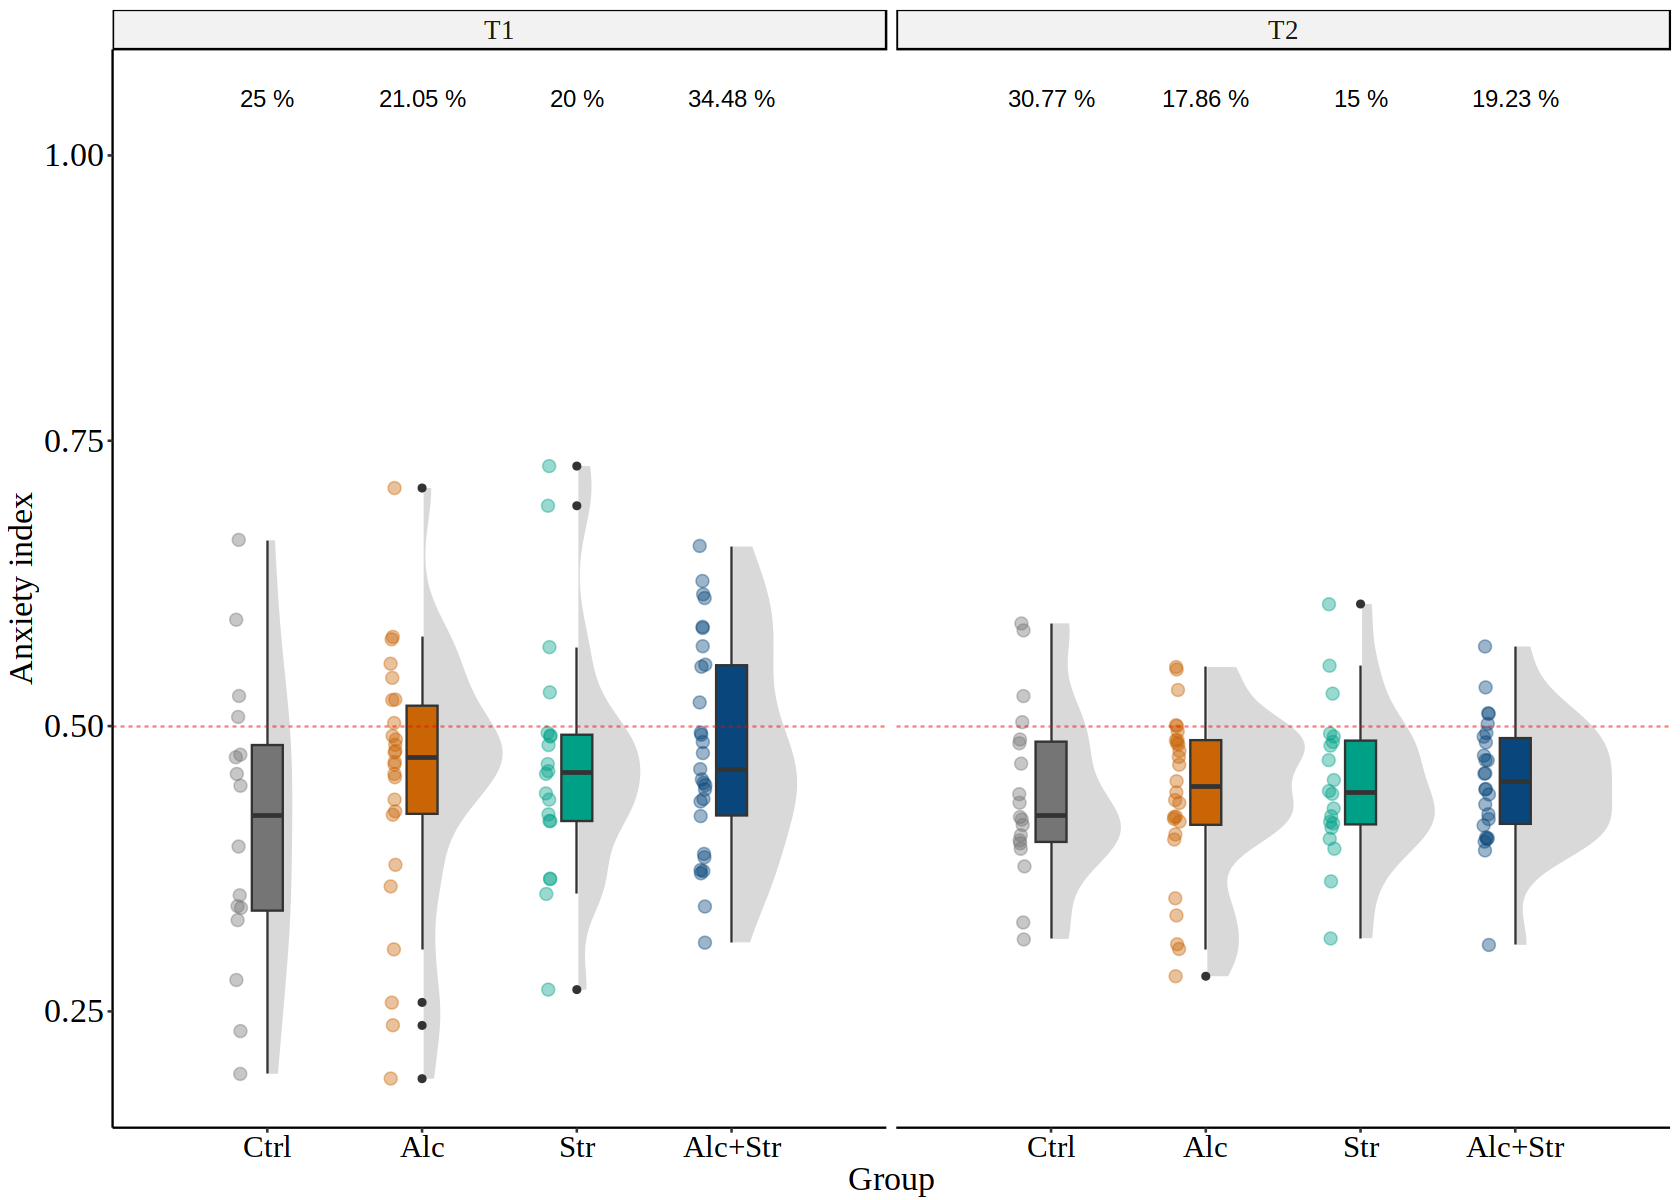

In [41]:
Plot_EPM.AI <- EPM_AI %>% 
  ggplot(aes(x = Group,y = Anxiety_index, 
             fill = Group)) + facet_grid(. ~ Stage) + 
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  xlab("Group") + ylab("Anxiety index") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_half_point(side = "l", aes(color = Group, fill = Group),
                  range_scale = .1, alpha = .4, size = 3) +
  geom_boxplot(width = .2) +
  theme_pubr() + theme_settings + 
  stat_compare_means(aes(label = ..p.signif..),method = "t.test",
                     label.x = 1.5, hide.ns = TRUE) + 
  theme(legend.position = "none") + 
  annotate("segment", x = 0, xend = 5, y = 0.5, yend = 0.5, colour = "red", linetype=2, alpha=0.5) + 
  geom_text(data = data.frame(Group = c(Perc_Group$Group[1],Perc_Group$Group[3]),
                                        Stage = c(Perc_Group$Stage[1],Perc_Group$Stage[2]), 
                                        label = c(paste0(round(Perc_Group$proportion[1],2)," %"),
                                                  paste0(round(Perc_Group$proportion[3],2)," %"))), 
            aes(x = 1, y = 1.05, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(Perc_Group$Group[3],Perc_Group$Group[4]),
                                        Stage = c(Perc_Group$Stage[3],Perc_Group$Stage[4]), 
                                        label = c(paste0(round(Perc_Group$proportion[2],2)," %"),
                                                  paste0(round(Perc_Group$proportion[4],2)," %"))), 
            aes(x = 2, y = 1.05, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(Perc_Group$Group[5],Perc_Group$Group[6]),
                                        Stage = c(Perc_Group$Stage[5],Perc_Group$Stage[6]), 
                                        label = c(paste0(round(Perc_Group$proportion[5],2)," %"),
                                                  paste0(round(Perc_Group$proportion[6],2)," %"))), 
            aes(x = 3, y = 1.05, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(Perc_Group$Group[7],Perc_Group$Group[8]),
                                        Stage = c(Perc_Group$Stage[7],Perc_Group$Stage[8]), 
                                        label = c(paste0(round(Perc_Group$proportion[7],2)," %"),
                                                  paste0(round(Perc_Group$proportion[8],2)," %"))), 
            aes(x = 4, y = 1.05, label = label), size = 5) 
Plot_EPM.AI

### 5.1 Visualization by sex but only Behavior one stage

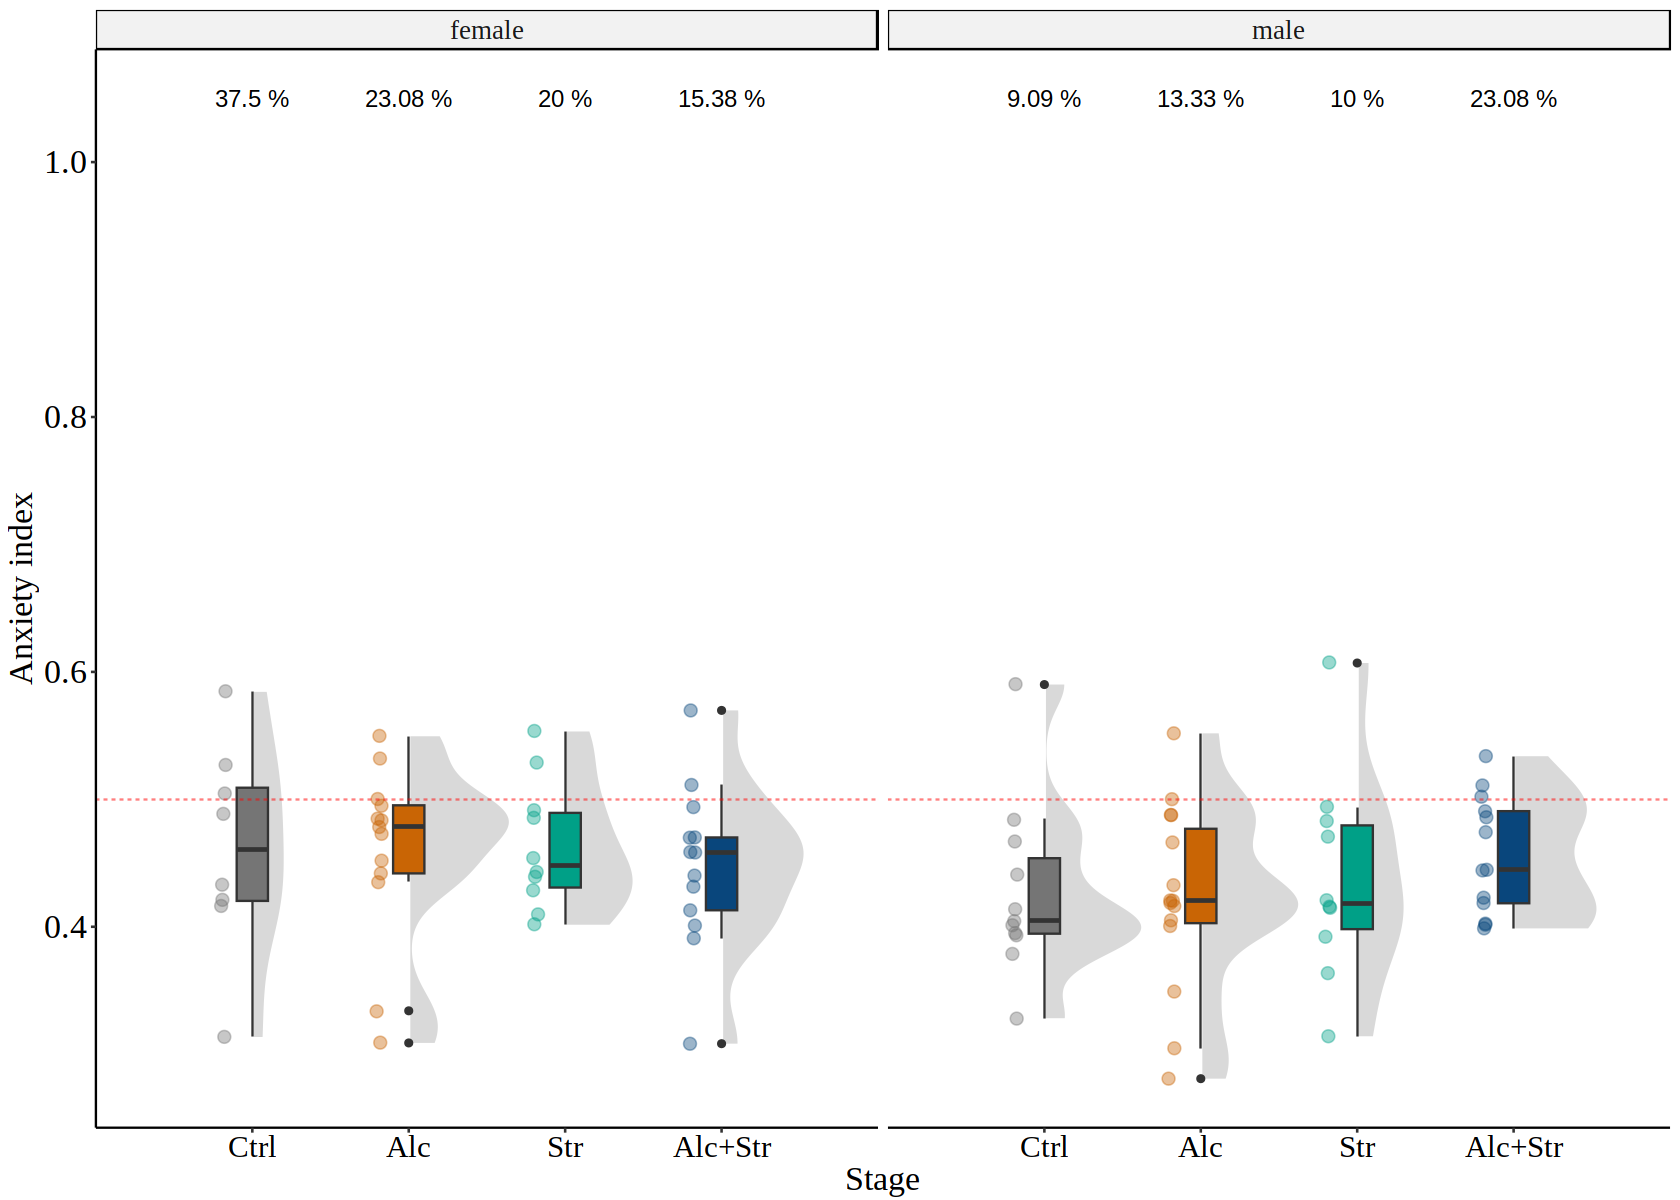

In [42]:
Sex.Plot_EPM.AI <- EPM_AI %>% filter(Stage == "T2") %>%
  ggplot(aes(x = Group,y = Anxiety_index, 
             fill = Group)) + facet_grid(. ~ Sex) +
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  xlab("Stage") + ylab("Anxiety index") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_half_point(side = "l", aes(color = Group, fill = Group),
                  range_scale = .1, alpha = .4, size = 3) +
  geom_boxplot(width = .2) +
  theme_pubr() + theme(legend.position = "none") +
  theme_settings  + 
  annotate("segment", x = 0, xend = 5, y = 0.5, yend = 0.5, colour = "red", linetype=2, alpha=0.5) + 
  geom_text(data = data.frame(Group = c(Perc_Group_sex$Group[1],Perc_Group_sex$Group[2]),
                              Sex = c(Perc_Group_sex$Sex[1],Perc_Group_sex$Sex[2]), 
                              label = c(paste0(round(Perc_Group_sex$proportion[1],2)," %"),
                                        paste0(round(Perc_Group_sex$proportion[2],2)," %"))), 
            aes(x = 1, y = 1.05, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(Perc_Group_sex$Group[3],Perc_Group_sex$Group[4]),
                              Sex = c(Perc_Group_sex$Sex[3],Perc_Group_sex$Sex[4]), 
                              label = c(paste0(round(Perc_Group_sex$proportion[3],2)," %"),
                                        paste0(round(Perc_Group_sex$proportion[4],2)," %"))), 
            aes(x = 2, y = 1.05, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(Perc_Group_sex$Group[5],Perc_Group_sex$Group[6]),
                              Sex = c(Perc_Group_sex$Sex[5],Perc_Group_sex$Sex[6]), 
                              label = c(paste0(round(Perc_Group_sex$proportion[5],2)," %"),
                                        paste0(round(Perc_Group_sex$proportion[6],2)," %"))), 
            aes(x = 3, y = 1.05, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(Perc_Group_sex$Group[7],Perc_Group_sex$Group[8]),
                              Sex = c(Perc_Group_sex$Sex[7],Perc_Group_sex$Sex[8]), 
                              label = c(paste0(round(Perc_Group_sex$proportion[7],2)," %"),
                                        paste0(round(Perc_Group_sex$proportion[8],2)," %"))), 
            aes(x = 4, y = 1.05, label = label), size = 5)
Sex.Plot_EPM.AI

`geom_smooth()` using formula = 'y ~ x'


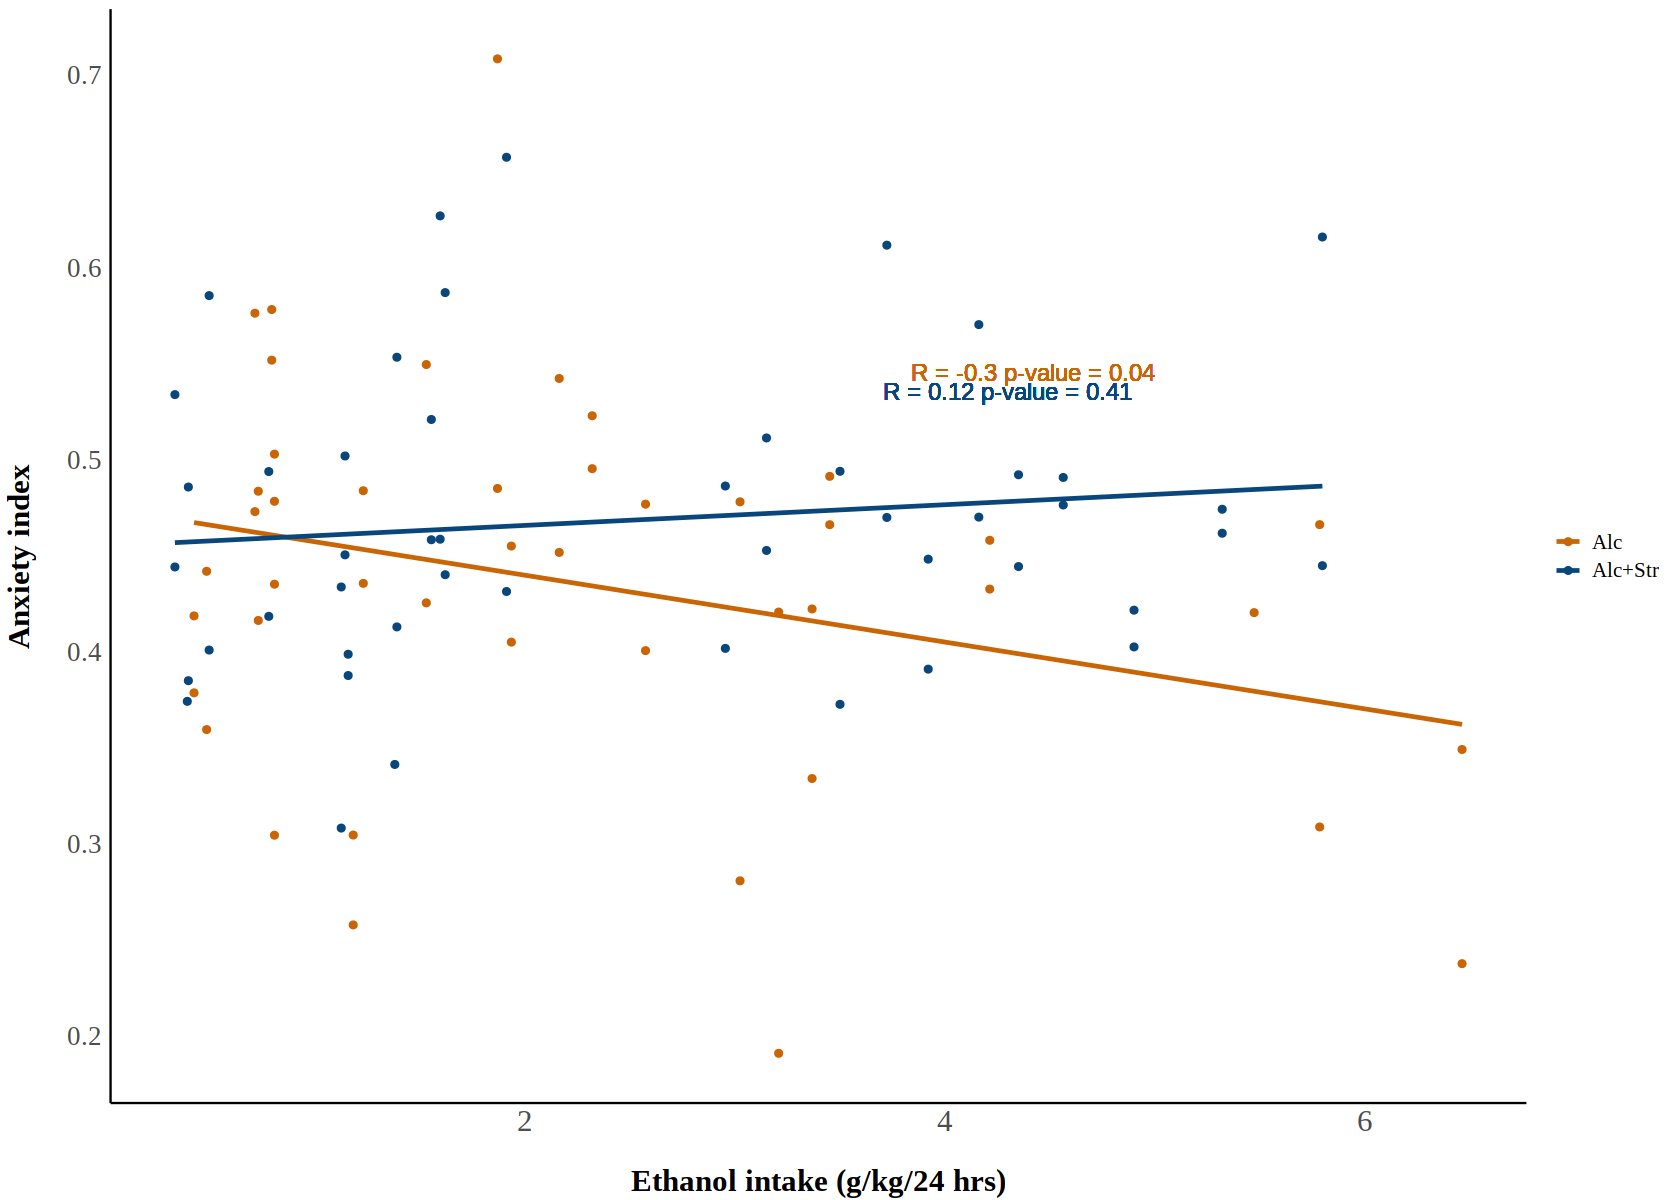

In [43]:
plot_corr_AI_AI <- ggplot(filtered_AI_AI) +
    geom_point(aes(y = Anxiety_index, x = main_intake, color = Group)) +
    geom_smooth(aes(y = Anxiety_index, x = main_intake, color = Group), method = "lm",  se = FALSE) +
    geom_text(aes(x = 5, y = 0.55, 
        label = paste("R =", round(cor_alc_AI.AI$estimate, 2), "p-value =", 
            round(cor_alc_AI.AI$p.value, 2))), 
              hjust = 1, vjust = 1, color = pal_group[2], size = 5) +
    geom_text(aes(x = 4.888, y = 0.54, 
        label = paste("R =", round(cor_alcstr_AI.AI$estimate, 2), "p-value =", 
            round(cor_alcstr_AI.AI$p.value, 2))), 
              hjust = 1, vjust = 1, color = pal_group[4], size = 5) +
    theme_modern() +
    ylab("Anxiety index") +
    xlab("Ethanol intake (g/kg/24 hrs)") +
    scale_color_manual(values = pal_group[c(2,4)]) + theme_settings +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18, face = "bold")) 
plot_corr_AI_AI

In [44]:
fem_filtered_df <- Report_DLC %>% filter(Stage == "T2") %>% filter(Sex == "female") %>% 
  mutate(Group = factor(Group, levels = c("Ctrl", "Alc","Str","Alc+Str")))

fem_bodycenter_vars <- grep(bodypart_point, names(fem_filtered_df), value = TRUE) %>% setdiff(paste0(bodypart_point,".total.time"))

fem_boxplot_list <- map(fem_bodycenter_vars, ~ ggplot(fem_filtered_df, aes(x = Group, y = .data[[.]], fill = Group)) +
  xlab("Stage") + ylab("Anxiety index") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_boxplot(width = .2) +
  theme_pubr() +
  geom_boxplot() +
  labs(x = "Group", y = .) +
  theme(legend.position = "none") +
  stat_compare_means(comparisons = list(c("Ctrl", "Alc"), c("Ctrl", "Str"), c("Ctrl", "Alc+Str"), 
                                        c("Alc", "Str"), c("Alc", "Alc+Str"), c("Str", "Alc+Str")), 
    method = "t.test", p.adjust.method = "fdr", label="p.format", hide.ns = TRUE)) 

In [45]:
male_filtered_df <- Report_DLC %>% filter(Stage == "T2") %>% filter(Sex == "male") %>% 
  mutate(Group = factor(Group, levels = c("Ctrl", "Alc","Str","Alc+Str")))

male_bodycenter_vars <- grep(bodypart_point, names(male_filtered_df), value = TRUE) %>% setdiff(paste0(bodypart_point,".total.time"))

male_boxplot_list <- map(fem_bodycenter_vars, ~ ggplot(male_filtered_df, aes(x = Group, y = .data[[.]], fill = Group)) +
  xlab("Stage") + ylab("Anxiety index") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_boxplot(width = .2) +
  theme_pubr() +
  geom_boxplot() +
  labs(x = "Group", y = .) +
  theme(legend.position = "none") +
  stat_compare_means(comparisons = list(c("Ctrl", "Alc"), c("Ctrl", "Str"), c("Ctrl", "Alc+Str"), 
                                        c("Alc", "Str"), c("Alc", "Alc+Str"), c("Str", "Alc+Str")), 
    method = "t.test", p.adjust.method = "fdr", label="p.format", hide.ns = TRUE) )

In [46]:
fem_boxplot_named <- fem_boxplot_list %>% set_names(fem_bodycenter_vars %>% clean_names())
male_boxplot_named <- male_boxplot_list %>% set_names(male_bodycenter_vars %>% clean_names())

In [47]:
fem_epm_plots1_20 <- plot_grid(plotlist = fem_boxplot_named[1:20])
fem_epm_plots21_40 <- plot_grid(plotlist = fem_boxplot_named[21:40])
fem_epm_plots41_60 <- plot_grid(plotlist = fem_boxplot_named[41:60])
fem_epm_plots61_71 <- plot_grid(plotlist = fem_boxplot_named[61:71])

In [48]:
male_epm_plots1_20 <- plot_grid(plotlist = male_boxplot_named[1:20])
male_epm_plots21_40 <- plot_grid(plotlist = male_boxplot_named[21:40])
male_epm_plots41_60 <- plot_grid(plotlist = male_boxplot_named[41:60])
male_epm_plots61_71 <- plot_grid(plotlist = male_boxplot_named[61:71])

## **6. Export data**

In [49]:
dir.create("Figures/EPM", recursive=TRUE, showWarnings = FALSE)

In [50]:
EPM_AI %>% dplyr::select(c(RID,Group,Sex,Batch,Stage,PI,PI_entries,Anxiety_index)) %>% left_join(Report_DLC %>% 
    dplyr::select(- c(file)), by = c("RID","Group","Sex","Batch","Stage")) %>% 
    write_csv(paste0(getwd(),"/Data/Behavior/EPM/DLC_tracked.csv"))

In [51]:
plot_objects <- ls(pattern = "epm_plots")

walk(plot_objects, ~ggsave(plot = get(.x), dpi=150, height = 15, width = 15, bg="white",
                        filename = paste0("Figures/EPM/", .x, ".png")))

In [52]:
ggsave(plot = Sex.Plot_EPM.AI, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/EPM/EPM_AI_sex_T2.png")

ggsave(plot = Plot_EPM.AI, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/EPM/EPM_AI_stage.png")


In [53]:
save(EPM_AI,Report_DLC,B1_Report_T2,B2_Report_T2,B3_Report_T2,B45_Report_T2,B2_Report_T1,
    B3_Report_T1,B45_Report_T1, Model_AI,emmeans_AI, filtered_AI_AI, file = paste0(getwd(),"/Data/Behavior_metricsEPM.RData"))

---
# **Novel object recognition**
---

## **2. Data preparation**

Reading files and set it all up.

Firstly, run the functions made by Sturman et al, (2020) and the modified function for NOR, the script is in:

[script](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLCAnalyzer_NOR.R)

Secondly, create the function to read, calibrating and analysis of the tracking accordingly with each batch recording (camera parameters)

Frames per second (fps):
- Batch 1: 7.5
- Batch 2: 30
- Batch 3: 7.5
- Batch 4: 7.5
- Batch 5: 16.6

#### Important: 

The nose is the point to consider if the rat is in which object

In [54]:
load("Data/Behavior_metricsNOR.RData")

In [55]:
NOR_input_folder <- paste0(getwd(),"/Data/Behavior/NOR/NOR/")
OR_input_folder <- paste0(getwd(),"/Data/Behavior/NOR/OR/")
RID_group <- read_csv("Data/RID_group.csv")

DLCmetrics_selectionNOR <- c('file', 'nose.ob.distance.moving', 'nose.ob.speed.moving','nose.ob.time.moving', 
                             'nose.ob.total.time', 'nose.ob.time.stationary','nose.ob.transitions','nose.nob.distance.moving', 'nose.nob.speed.moving',
                             'nose.nob.time.moving', 'nose.nob.total.time', 'nose.nob.time.stationary','nose.nob.transitions')

Rows: 96 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): RID, Group, Sex, Batch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### **2.1 Create functions accordingly with each batch**

In [56]:
# Create function ---------------------------------------------------------

ROpipeline_134 <- function(path){
    Tracking <- ReadDLCDataFromCSV(file = path, fps = 7.5)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95)
    Tracking <- CalibrateTrackingData(Tracking, "area",in.metric = 42*42, points = c("tl","tr","br","bl"))
    PlotPointData(Tracking, points = c("nose"))
    zoneinfo <- read.table(paste0(getwd(),"/code/DLC/RO.csv"), sep = ";", header = T)
    Tracking <- AddZones(Tracking,zoneinfo)
    Tracking <- objet(Tracking, 7)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.2))
    Tracking <- AnalysisRO(Tracking, movement_cutoff = 4,integration_period = 5,points = "nose", nosedips = FALSE)
    return(Tracking)
  }

ROpipeline_2 <- function(path){
    Tracking <- ReadDLCDataFromCSV(file = path, fps = 30)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95)
    Tracking <- CalibrateTrackingData(Tracking, "area",in.metric = 42*42, points = c("tl","tr","br","bl"))
    PlotPointData(Tracking, points = c("nose"))
    zoneinfo <- read.table(paste0(getwd(),"/code/DLC/RO.csv"), sep = ";", header = T)
    Tracking <- AddZones(Tracking,zoneinfo)
    Tracking <- objet(Tracking, 7)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.2))
    Tracking <- AnalysisRO(Tracking, movement_cutoff = 4,integration_period = 5,points = "nose", nosedips = FALSE)
    return(Tracking)
  }

ROpipeline_5 <- function(path){
    Tracking <- ReadDLCDataFromCSV(file = path, fps = 16.6)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95)
    Tracking <- CalibrateTrackingData(Tracking, "area",in.metric = 42*42, points = c("tl","tr","br","bl"))
    PlotPointData(Tracking, points = c("nose"))
    zoneinfo <- read.table(paste0(getwd(),"/code/DLC/RO.csv"), sep = ";", header = T)
    Tracking <- AddZones(Tracking,zoneinfo)
    Tracking <- objet(Tracking, 7)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.2))
    Tracking <- AnalysisRO(Tracking, movement_cutoff = 4,integration_period = 5,points = "nose", nosedips = FALSE)
    return(Tracking)
  }

### **2.2 Analyze tracking with DLC analyzer**

In [57]:
# Batch 1

### OR ###
B1_files_OR <- list.files(OR_input_folder, pattern = "G1", recursive = T)
B1_TrackingAll_OR <- RunPipeline(B1_files_OR,OR_input_folder,FUN = ROpipeline_134)
B1_Report_OR <- MultiFileReport(B1_TrackingAll_OR) #%>% dplyr::select(all_of(DLCmetrics_selectionNOR))

### NOR ###

B1_files_NOR <- list.files(NOR_input_folder, pattern = "G1", recursive = T)
B1_TrackingAll_NOR <- RunPipeline(B1_files_NOR,NOR_input_folder,FUN = ROpipeline_134)
B1_Report_NOR <- MultiFileReport(B1_TrackingAll_NOR) #%>% dplyr::select(all_of(DLCmetrics_selectionNOR))


[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area

In [58]:
# Batch 2

### OR ###
B2_files_OR <- list.files(OR_input_folder, pattern = "G[2,7,8]", recursive = T)
B2_TrackingAll_OR <- RunPipeline(B2_files_OR,OR_input_folder,FUN = ROpipeline_2)
B2_Report_OR <- MultiFileReport(B2_TrackingAll_OR) #%>% dplyr::select(all_of(DLCmetrics_selectionNOR))

### NOR ###
B2_files_NOR <- list.files(NOR_input_folder, pattern = "G[2,7,8]", recursive = T)
B2_TrackingAll_NOR <- RunPipeline(B2_files_NOR,NOR_input_folder,FUN = ROpipeline_2)
B2_Report_NOR <- MultiFileReport(B2_TrackingAll_NOR) #%>% dplyr::select(all_of(DLCmetrics_selectionNOR))


[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area

In [59]:
# Batch 3

### OR ###
B3_files_OR <- list.files(OR_input_folder, pattern = "G3", recursive = T)
B3_TrackingAll_OR <- RunPipeline(B3_files_OR,OR_input_folder,FUN = ROpipeline_134)
B3_Report_OR <- MultiFileReport(B3_TrackingAll_OR) #%>% dplyr::select(all_of(DLCmetrics_selectionNOR))

### NOR ###
B3_files_NOR <- list.files(NOR_input_folder, pattern = "G3", recursive = T)
B3_TrackingAll_NOR <- RunPipeline(B3_files_NOR,NOR_input_folder,FUN = ROpipeline_134)
B3_Report_NOR <- MultiFileReport(B3_TrackingAll_NOR) #%>% dplyr::select(all_of(DLCmetrics_selectionNOR))


[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area

In [60]:
# Batch 4

### OR ###
B4_files_OR <- list.files(OR_input_folder, pattern = "G4", recursive = T)
B4_TrackingAll_OR <- RunPipeline(B4_files_OR,OR_input_folder,FUN = ROpipeline_134)
B4_Report_OR <- MultiFileReport(B4_TrackingAll_OR) #%>% dplyr::select(all_of(DLCmetrics_selectionNOR))

### NOR ###
B4_files_NOR <- list.files(NOR_input_folder, pattern = "G4", recursive = T)
B4_TrackingAll_NOR <- RunPipeline(B4_files_NOR,NOR_input_folder,FUN = ROpipeline_134)
B4_Report_NOR <- MultiFileReport(B4_TrackingAll_NOR) #%>% dplyr::select(all_of(DLCmetrics_selectionNOR))
 

[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area

In [61]:
# Batch 5

### OR ###
B5_files_OR <- list.files(OR_input_folder, pattern = "G[5,6]", recursive = T)
B5_TrackingAll_OR <- RunPipeline(B5_files_OR,OR_input_folder,FUN = ROpipeline_5)
B5_Report_OR <- MultiFileReport(B5_TrackingAll_OR) #%>% dplyr::select(all_of(DLCmetrics_selectionNOR))

### NOR ###
B5_files_NOR <- list.files(NOR_input_folder, pattern = "G[5,6]", recursive = T)
B5_TrackingAll_NOR <- RunPipeline(B5_files_NOR,NOR_input_folder,FUN = ROpipeline_5)
B5_Report_NOR <- MultiFileReport(B5_TrackingAll_NOR) #%>% dplyr::select(all_of(DLCmetrics_selectionNOR))
 

[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points with likelihood < 0.95"
[1] "interpolating points which are outside of the existence area

### **2.3 Binding and arranging**

In [62]:
Report_NOR_joined <- rbind.data.frame(B1_Report_NOR,B2_Report_NOR,B3_Report_NOR,B4_Report_NOR,B5_Report_NOR) 
NOR_Report_DLC <- Report_NOR_joined %>% 
             add_column(RID = paste0("sub-", str_split(Report_NOR_joined$file, n = 4, pattern = "_") %>% 
                                     map_chr(~ .x %>% extract(2))) ,.before = 1) %>% 
             right_join(RID_group, by = "RID")



## **3. Analysis**


### **3.1 Novel object recognition**

In [63]:
NOR_timeObj <- NOR_Report_DLC %>% dplyr::select(RID,Group,Batch,Sex,nose.ob.total.time,nose.nob.total.time) %>%
                pivot_longer(cols = c(nose.ob.total.time, nose.nob.total.time), 
                             names_to = "Object", values_to = "Time") %>%
                mutate(Group = factor(Group, levels = c("Ctrl", "Alc","Str","Alc+Str")),
                RID = factor(RID),
                Object = factor(Object),
                Sex = factor(Sex),
                Object = case_when(Object == "nose.ob.total.time" ~ "Familiar",
                                   Object == "nose.nob.total.time" ~ "Novel")) %>% 
                pivot_wider(names_from = Object, values_from = Time) %>% 
                mutate(resta = (Novel-Familiar),
                       suma = (Novel+Familiar),
                       PI = if_else(is.nan(Novel/suma),0,(Novel/suma))) %>% na.omit()  %>%
                convert_as_factor(Batch)

In [64]:
NOR_entries <- NOR_Report_DLC %>% dplyr::select(RID,Group,Batch,Sex,nose.ob.transitions,nose.nob.transitions) %>%
                pivot_longer(cols = c(nose.ob.transitions, nose.nob.transitions	), 
                             names_to = "Obj_entries", values_to = "Entries") %>%
                mutate(Group = factor(Group, levels = c("Ctrl", "Alc","Str","Alc+Str")),
                RID = factor(RID),
                Obj_entries = factor(Obj_entries),
                Sex = factor(Sex),
                Obj_entries = case_when(Obj_entries == "nose.ob.transitions" ~ "Familiar_entries",
                                        Obj_entries == "nose.nob.transitions" ~ "Novel_entries")) %>% 
                pivot_wider(names_from = Obj_entries, values_from = Entries) %>% 
                mutate(resta_entries = (Novel_entries-Familiar_entries),
                       suma_entries = (Familiar_entries+Novel_entries),
                       PI_entries = if_else(is.nan(Novel_entries/suma_entries),0,(Novel_entries/suma_entries))) %>% na.omit()  %>%
                convert_as_factor(Batch)

### **3.2 Interaction index**

In [65]:
NOR_II <- left_join(NOR_timeObj,NOR_entries) %>% mutate(Interaction_index = (( ((PI) + (PI_entries)) / 2 ) ) ) %>% 
          convert_as_factor(Sex,Group)

Joining with `by = join_by(RID, Group, Batch, Sex)`


### **3.4 Relationship with ethanol consumption**

In [66]:
filtered_NOR_II <- NOR_II %>% filter(Group == "Alc" | Group == "Alc+Str") %>% 
    dplyr::select(RID,Group,Sex,PI)
filtered_Alcohol_intake <- Alcohol_intake %>% filter(Phase == "Model", Session == 20) %>% 
    dplyr::select(RID,Group,Sex,Age,Weight_kg,main_intake)

filtered_Alcohol_intake <- filtered_Alcohol_intake %>% anti_join(filtered_Alcohol_intake %>% 
                        identify_outliers(main_intake) %>% dplyr::select(-c(is.outlier,is.extreme)))

Joining with `by = join_by(RID, Group, Sex, Age, Weight_kg, main_intake)`


In [67]:
filtered_II_AI <- filtered_NOR_II %>% left_join(filtered_Alcohol_intake, by = c("RID","Group", "Sex"))
cor_alc_II.AI <- cor.test(filtered_II_AI %>% filter(Group == "Alc") %>% pull(PI), 
    filtered_II_AI %>% filter(Group == "Alc") %>% pull(main_intake))
cor_alcstr_II.AI <- cor.test(filtered_II_AI %>% filter(Group == "Alc+Str") %>% pull(PI), 
    filtered_II_AI %>% filter(Group == "Alc+Str") %>% pull(main_intake))

## **4. Exploratory data analysis**

In [68]:
NOR_timeObj %>% skimr::skim()

,skim_type,skim_variable,n_missing,complete_rate,factor.ordered,factor.n_unique,factor.top_counts,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<lgl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,factor,RID,0,1,FALSE,88,"sub: 1, sub: 1, sub: 1, sub: 1",NA,NA,NA,NA,NA,NA,NA,NA
2,factor,Group,0,1,FALSE,4,"Alc: 27, Alc: 26, Str: 19, Ctr: 16",NA,NA,NA,NA,NA,NA,NA,NA
3,factor,Batch,0,1,FALSE,8,"B8: 18, B5: 15, B4: 13, B7: 12",NA,NA,NA,NA,NA,NA,NA,NA
4,factor,Sex,0,1,FALSE,2,"fem: 44, mal: 44",NA,NA,NA,NA,NA,NA,NA,NA
5,numeric,Familiar,0,1,NA,NA,NA,24.0128970,19.5174056,2.633333,13.6666667,19.7333333,27.6083333,163.4337349,▇▁▁▁▁
6,numeric,Novel,0,1,NA,NA,NA,32.0923558,22.5710490,0.000000,17.1018072,27.0407631,38.6416667,139.2771084,▇▅▂▁▁
7,numeric,resta,0,1,NA,NA,NA,8.0794587,30.8078099,-163.433735,-6.0333333,6.4666667,21.6500000,103.3333333,▁▁▃▇▁
8,numeric,suma,0,1,NA,NA,NA,56.1052528,28.8381969,21.144578,38.8000000,50.6833333,66.6250000,197.3493976,▇▃▁▁▁
9,numeric,PI,0,1,NA,NA,NA,0.5613471,0.1930613,0.000000,0.4220872,0.5748228,0.7142849,0.9652442,▁▃▆▇▂


── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             88        
Number of columns          9         
_______________________              
Column type frequency:               
  factor                   4         
  numeric                  5         
________________________             
Group variables            None      

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 RID                   0             1 FALSE         88
2 Group                 0             1 FALSE          4
3 Batch                 0             1 FALSE          8
4 Sex                   0             1 FALSE          2
  top_counts                        
1 sub: 1, sub: 1, sub: 1, sub: 1    
2 Alc: 27, Alc: 26, Str: 19, Ctr: 16
3 B8: 18, B5: 15, B4: 13, B7: 12    
4 fem: 44, mal: 44                  

── Variable type: numeric 

In [69]:
# NOR_AI_extremes <- NOR_II %>% group_by(Group,Sex) %>% identify_outliers(PI)
# NOR_AI_extremes_NA <- NOR_AI_extremes %>% filter(Sex == "male") %>% dplyr::select(-c(is.outlier,is.extreme))
# NOR_II <- NOR_II %>% anti_join(NOR_AI_extremes) 

In [70]:
NOR_II

RID,Group,Batch,Sex,Familiar,Novel,resta,suma,PI,Familiar_entries,Novel_entries,resta_entries,suma_entries,PI_entries,Interaction_index
<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sub-013,Alc,B1,male,27.466667,34.40000,6.9333333,61.86667,0.5560345,21,24,3,45,0.5333333,0.5446839
sub-015,Ctrl,B1,male,17.333333,58.53333,41.2000000,75.86667,0.7715290,16,36,20,52,0.6923077,0.7319183
sub-019,Alc,B2,female,12.300000,34.80000,22.5000000,47.10000,0.7388535,22,44,22,66,0.6666667,0.7027601
sub-020,Alc,B2,female,12.633333,40.53333,27.9000000,53.16667,0.7623824,16,30,14,46,0.6521739,0.7072782
sub-021,Ctrl,B2,female,6.533333,64.63333,58.1000000,71.16667,0.9081967,14,42,28,56,0.7500000,0.8290984
sub-022,Alc,B2,female,25.166667,62.83333,37.6666667,88.00000,0.7140152,28,36,8,64,0.5625000,0.6382576
sub-023,Ctrl,B2,female,19.700000,29.06667,9.3666667,48.76667,0.5960355,28,34,6,62,0.5483871,0.5722113
sub-024,Alc,B2,female,13.866667,21.60000,7.7333333,35.46667,0.6090226,36,32,-4,68,0.4705882,0.5398054
sub-028,Ctrl,B2,male,39.300000,60.70000,21.4000000,100.00000,0.6070000,26,32,6,58,0.5517241,0.5793621


### **4.1 Stats (hyphotesis testing)**

In [71]:
NOR.shapiro <-NOR_II %>% 
    shapiro_test(PI)
NOR.shapiro

variable,statistic,p
<chr>,<dbl>,<dbl>
PI,0.9812294,0.2323458


In [72]:
NOR.levene <-NOR_II %>% 
    levene_test(PI~Group)
NOR.levene

df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
3,84,0.608788,0.6111397


In [73]:
NOR_novel.aov <- anova_test(data = NOR_II, dv = PI, wid = RID,
           between = c(Group,Sex))
NOR_novel.aov

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Group,3,80,3.825,0.013,*,0.125
2,Sex,1,80,0.525,0.471,,0.007
3,Group:Sex,3,80,0.484,0.694,,0.018


In [74]:
NOR_novel.aov<- anova_test(data = NOR_II, dv = PI, wid = RID,
           between = c(Sex))
NOR_novel.aov

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Sex,1,86,0.226,0.635,,0.003


In [75]:
NOR_novel.pwcC <- NOR_II %>% 
  pairwise_t_test(
    PI ~ Group,  
    p.adjust.method = "fdr")
NOR_novel.pwcC

,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,PI,Ctrl,Alc,16,27,0.92500,ns,0.9250,ns
2,PI,Ctrl,Str,16,19,0.00799,**,0.0240,*
3,PI,Alc,Str,27,19,0.00207,**,0.0124,*
4,PI,Ctrl,Alc+Str,16,26,0.34600,ns,0.4150,ns
5,PI,Alc,Alc+Str,27,26,0.23100,ns,0.3470,ns
6,PI,Str,Alc+Str,19,26,0.04280,*,0.0856,ns


In [76]:
Sex.NOR_novel.pwcC <- NOR_II %>% group_by(Sex) %>%
  pairwise_t_test(
    PI ~ Group,  
    p.adjust.method = "fdr")
Sex.NOR_novel.pwcC

,Sex,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,female,PI,Ctrl,Alc,8,13,0.5150,ns,0.6180,ns
2,female,PI,Ctrl,Str,8,10,0.0290,*,0.1740,ns
3,female,PI,Alc,Str,13,10,0.0713,ns,0.1830,ns
4,female,PI,Ctrl,Alc+Str,8,13,0.4450,ns,0.6180,ns
5,female,PI,Alc,Alc+Str,13,13,0.8960,ns,0.8960,ns
6,female,PI,Str,Alc+Str,10,13,0.0913,ns,0.1830,ns
7,male,PI,Ctrl,Alc,8,14,0.5540,ns,0.5570,ns
8,male,PI,Ctrl,Str,8,9,0.1000,ns,0.3010,ns
9,male,PI,Alc,Str,14,9,0.0154,*,0.0922,ns


### **4.1 Stats (Modelling)**

In [77]:
Model_PI <- lm(formula = PI ~ Group*Sex+Batch, data = NOR_II)

In [78]:
emmeans_PI <- emmeans(Model_PI, specs = pairwise ~ Group|Sex, adjust="fdr")
emmeans_PI$contrasts %>% as_tibble() %>% add_significance() #%>% filter(p.value < 0.05) 

contrast,Sex,estimate,SE,df,t.ratio,p.value,p.value.signif
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ctrl - Alc,female,0.04129379,0.08351445,73,0.4944509,0.7440499,ns
Ctrl - Str,female,0.13732433,0.09755800,73,1.4076173,0.7138376,ns
Ctrl - (Alc+Str),female,0.07222385,0.10078327,73,0.7166254,0.7138376,ns
Alc - Str,female,0.09603054,0.09090264,73,1.0564109,0.7138376,ns
Alc - (Alc+Str),female,0.03093006,0.09437512,73,0.3277353,0.7440499,ns
Str - (Alc+Str),female,-0.06510048,0.08557893,73,-0.7607068,0.7138376,ns
Ctrl - Alc,male,-0.08753678,0.08745880,73,-1.0008916,0.4550865,ns
Ctrl - Str,male,0.12725472,0.09956375,73,1.2781230,0.4105104,ns
Ctrl - (Alc+Str),male,0.05246505,0.09660171,73,0.5431068,0.5887108,ns


In [79]:
emmeans_PI <- emmeans(Model_PI, specs = pairwise ~ Group|Sex, adjust="none")
emmeans_PI$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance()

contrast,Sex,estimate,SE,df,t.ratio,p.value,p.value.signif
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Alc - Str,male,0.2147915,0.09371658,73,2.291926,0.02479549,*


In [80]:
eff_size_PI <- eff_size(emmeans_PI,sigma = sigma(Model_PI),edf = 71)
eff_size_PI

Since 'object' is a list, we are using the contrasts already present.



Sex = female:
 contrast           effect.size    SE df lower.CL upper.CL
 (Ctrl - Alc)             0.223 0.452 73   -0.677    1.123
 (Ctrl - Str)             0.742 0.531 73   -0.316    1.800
 (Ctrl - (Alc+Str))       0.390 0.545 73   -0.697    1.477
 (Alc - Str)              0.519 0.493 73   -0.464    1.501
 (Alc - (Alc+Str))        0.167 0.510 73   -0.849    1.184
 (Str - (Alc+Str))       -0.352 0.463 73   -1.275    0.572

Sex = male:
 contrast           effect.size    SE df lower.CL upper.CL
 (Ctrl - Alc)            -0.473 0.474 73   -1.418    0.472
 (Ctrl - Str)             0.688 0.541 73   -0.391    1.766
 (Ctrl - (Alc+Str))       0.283 0.522 73   -0.758    1.325
 (Alc - Str)              1.160 0.516 73    0.133    2.188
 (Alc - (Alc+Str))        0.756 0.509 73   -0.258    1.771
 (Str - (Alc+Str))       -0.404 0.458 73   -1.317    0.509

Results are averaged over the levels of: Batch 
sigma used for effect sizes: 0.1851 
Confidence level used: 0.95 

In [81]:
allNOR_metrics <- NOR_II %>% dplyr::select(RID,Group,Batch,Sex,PI,PI_entries,Interaction_index) %>% 
    left_join(NOR_Report_DLC %>% dplyr::select(-file)) %>% mutate(Group = fct_relevel(Group, "Ctrl", "Alc", "Str", "Alc+Str"))

Models_allNOR_metrics <- allNOR_metrics %>% dplyr::select(5:ncol(NOR_Report_DLC)) %>% 
    colnames() %>% map(~ lm(eval(paste0(.x," ~ Group*Sex + Batch")), data = allNOR_metrics)) %>% 
    set_names(allNOR_metrics %>% dplyr::select(5:ncol(NOR_Report_DLC)) %>% colnames())

suppressMessages(invisible(capture.output(
Contrast_allNOR_metrics <- Models_allNOR_metrics %>%
    map(~ contrast(emmeans(.x,~ Group|Sex), method = "pairwise", adjust = "none")) %>% 
    set_names(allNOR_metrics %>% dplyr::select(5:ncol(NOR_Report_DLC)) %>% colnames())
    )))

suppressMessages(invisible(capture.output(
Eff_size_allNOR_metrics <- allNOR_metrics %>% dplyr::select(5:ncol(NOR_Report_DLC)) %>% colnames() %>%
    map(~ eff_size(Contrast_allNOR_metrics[[.x]], sigma = sigma(Models_allNOR_metrics[[.x]]),
                    edf = df.residual(Models_allNOR_metrics[[.x]]) ) ) %>% 
    set_names(allNOR_metrics %>% dplyr::select(5:ncol(NOR_Report_DLC)) %>% colnames()) 
    )))

Joining with `by = join_by(RID, Group, Batch, Sex)`


In [82]:
NOR_names_4pls <- Contrast_allNOR_metrics %>% map(~ .x %>% as_tibble() %>% 
    filter(p.value < 0.05) %>% 
    add_significance() ) %>% 
    keep(~ nrow(.x) > 0)

## **5. Visualization**


In [83]:
NOR.Perc_Group <- NOR_II %>% group_by(Group) %>% 
              summarise(proportion = (sum(Interaction_index > 0.5,na.rm = T)/(sum(Interaction_index < 0.5,na.rm = T) + sum(Interaction_index > 0.5,na.rm = T))) * 100 )
NOR.Perc_Group_sex <- NOR_II %>% group_by(Group,Sex) %>% 
              summarise(proportion = (sum(Interaction_index > 0.5,na.rm = T)/(sum(Interaction_index < 0.5,na.rm = T) + sum(Interaction_index > 0.5,na.rm = T))) * 100 )


`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


In [84]:
NOR.Perc_Group <- NOR_II %>% group_by(Group) %>% 
              summarise(proportion = (sum(PI > 0.5,na.rm = T)/(sum(PI < 0.5,na.rm = T) + sum(PI > 0.5,na.rm = T))) * 100 )
NOR.Perc_Group_sex <- NOR_II %>% group_by(Group,Sex) %>% 
              summarise(proportion = (sum(PI > 0.5,na.rm = T)/(sum(PI < 0.5,na.rm = T) + sum(PI > 0.5,na.rm = T))) * 100 )

`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


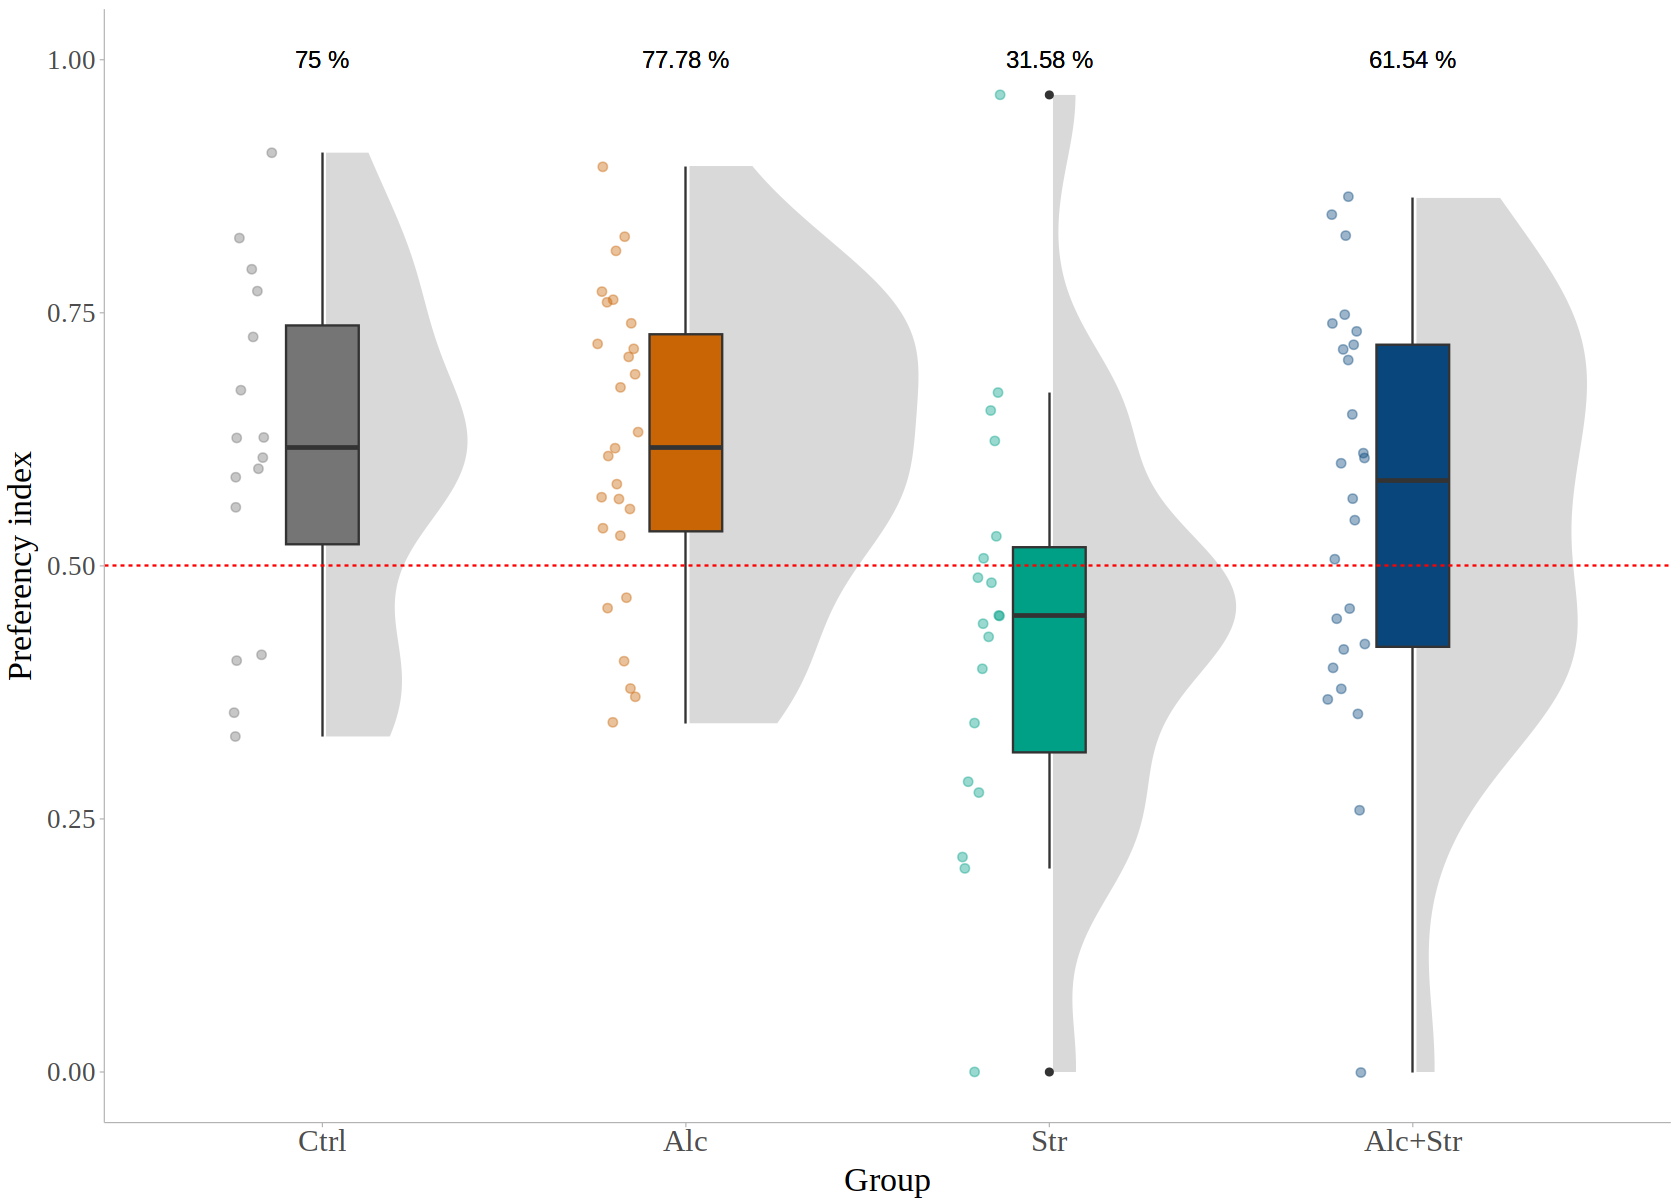

In [85]:
plot_NOR <- NOR_II %>%
  ggplot(aes(x = Group,y = PI, 
             fill = Group)) + 
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  gghalves::geom_half_point(aes(color = Group),
                            side = "l", 
                            range_scale = .3, 
                            alpha = .4, size = 2) +
  geom_boxplot(width = .2) + 
  #stat_pvalue_manual(NOR_novel.pwcC,
  #                   tip.length = 0.03, hide.ns = FALSE) +
  #labs(subtitle = get_test_label(NOR_novel.pwcC, 
  #                               detailed = TRUE)) +
  #stat_compare_means(aes(label = after_stat(p.signif)), 
  #                method = "t.test", ref.group = "Ctrl", hide.ns = TRUE) +
  ylab("Preferency index") +
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) + 
  theme_ggdist() +
  theme(text = element_text(size = 18), legend.position = "none",
        plot.subtitle = element_text(hjust = 1)) + 
  geom_hline(yintercept=0.5, linetype="dashed", color = "red") + 
  theme_settings + 
  geom_text(data = data.frame(Group = c(NOR.Perc_Group$Group[1],NOR.Perc_Group$Group[1]),
                                        label = c(paste0(round(NOR.Perc_Group$proportion[1],2)," %"))), 
            aes(x = 1, y = 1, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(NOR.Perc_Group$Group[2],NOR.Perc_Group$Group[2]),
                                        label = c(paste0(round(NOR.Perc_Group$proportion[2],2)," %"))), 
            aes(x = 2, y = 1, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(NOR.Perc_Group$Group[3],NOR.Perc_Group$Group[3]),
                                        label = c(paste0(round(NOR.Perc_Group$proportion[3],2)," %"))), 
            aes(x = 3, y = 1, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(NOR.Perc_Group$Group[4],NOR.Perc_Group$Group[4]),
                                        label = c(paste0(round(NOR.Perc_Group$proportion[4],2)," %"))), 
            aes(x = 4, y = 1, label = label), size = 5)
plot_NOR

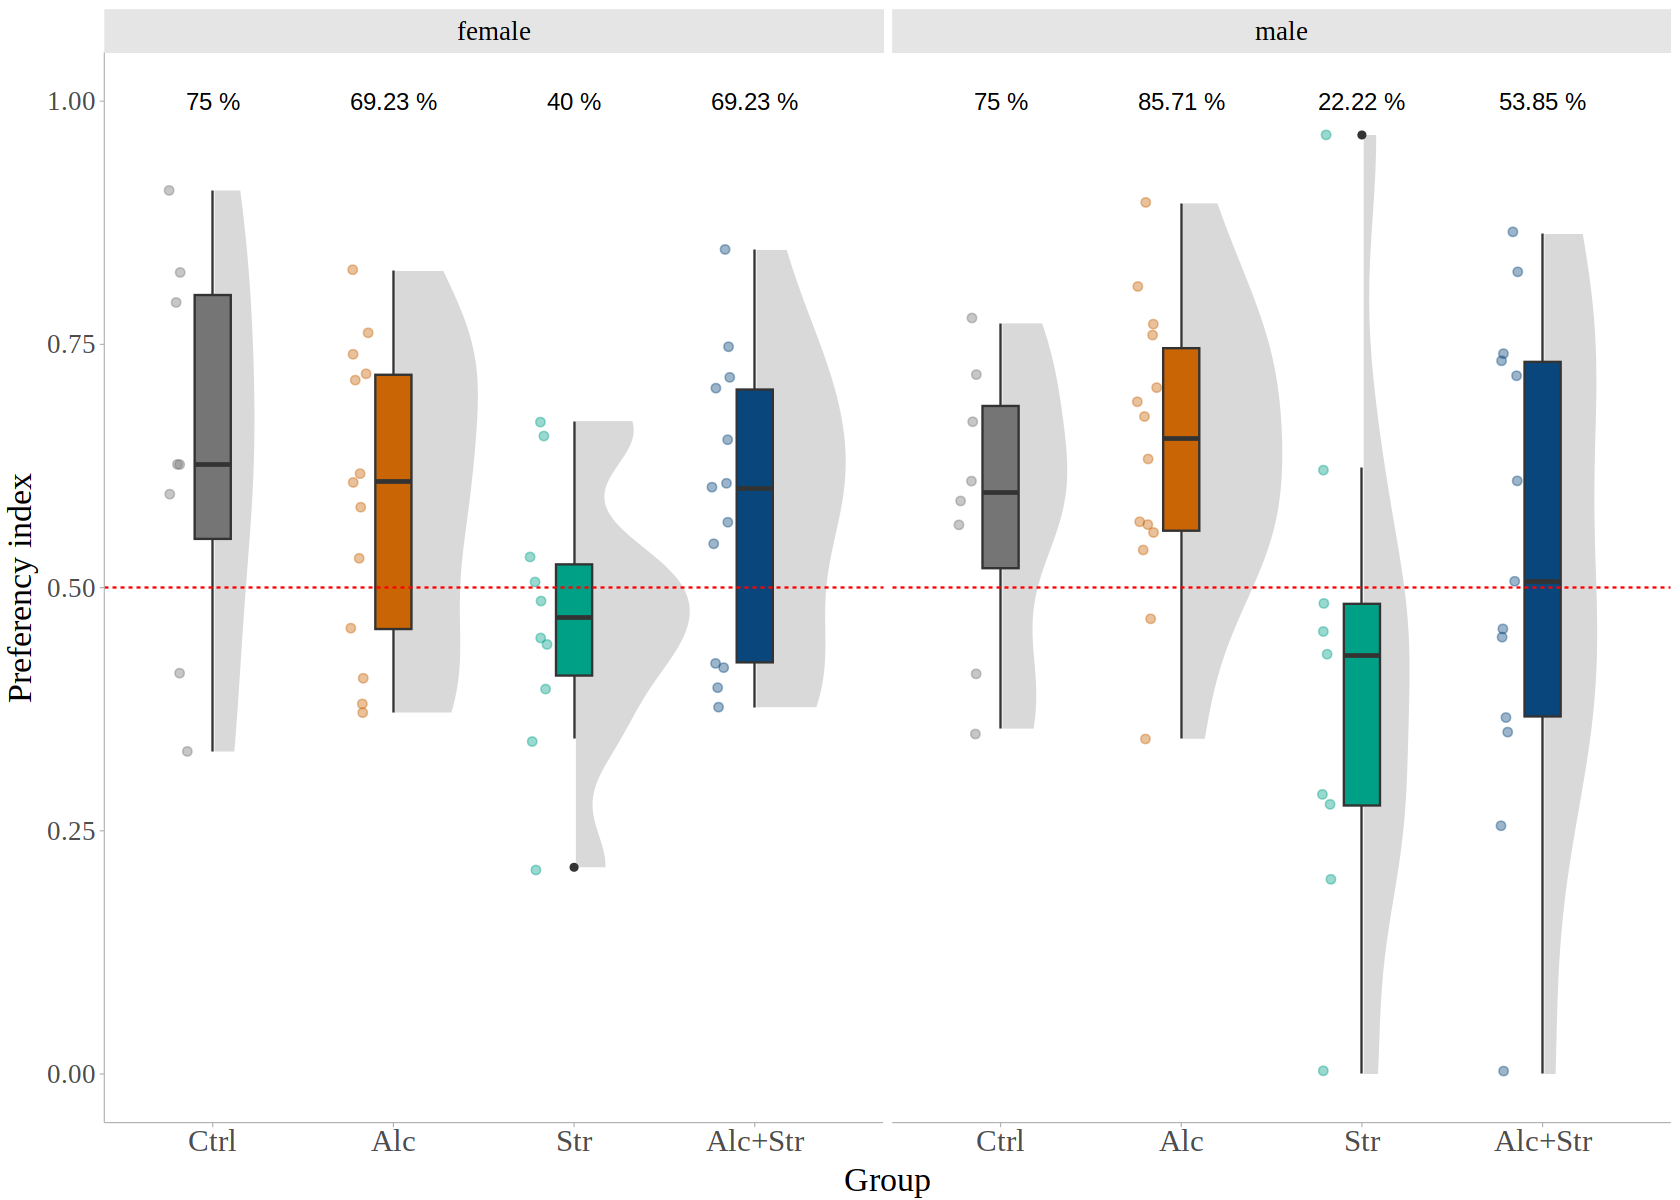

In [86]:
plot_NOR_sex <- NOR_II %>%
  ggplot(aes(x = Group,y = PI, 
             fill = Group)) + facet_grid(. ~ Sex) +
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  gghalves::geom_half_point(aes(color = Group),
                            side = "l", 
                            range_scale = .3, 
                            alpha = .4, size = 2) +
  geom_boxplot(width = .2) + 
  #stat_pvalue_manual(NOR_novel.pwcC,
  #                   tip.length = 0.03, hide.ns = FALSE) +
  #labs(subtitle = get_test_label(NOR_novel.pwcC, 
  #                               detailed = TRUE)) +
  #stat_compare_means(aes(label = after_stat(p.signif)), 
  #                method = "t.test", ref.group = "Ctrl", hide.ns = TRUE) +
  ylab("Preferency index") +
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) + 
  theme_ggdist() +
  theme(text = element_text(size = 18), legend.position = "none",
        plot.subtitle = element_text(hjust = 1)) + 
  geom_hline(yintercept=0.5, linetype="dashed", color = "red") + 
  theme_settings + 
  geom_text(data = data.frame(Group = c(NOR.Perc_Group_sex$Group[1],NOR.Perc_Group_sex$Group[2]),
                              Sex = c(NOR.Perc_Group_sex$Sex[1],NOR.Perc_Group_sex$Sex[2]), 
                              label = c(paste0(round(NOR.Perc_Group_sex$proportion[1],2)," %"),
                                        paste0(round(NOR.Perc_Group_sex$proportion[2],2)," %"))), 
            aes(x = 1, y = 1, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(NOR.Perc_Group_sex$Group[3],NOR.Perc_Group_sex$Group[4]),
                              Sex = c(NOR.Perc_Group_sex$Sex[3],NOR.Perc_Group_sex$Sex[4]), 
                              label = c(paste0(round(NOR.Perc_Group_sex$proportion[3],2)," %"),
                                        paste0(round(NOR.Perc_Group_sex$proportion[4],2)," %"))), 
            aes(x = 2, y = 1, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(NOR.Perc_Group_sex$Group[5],NOR.Perc_Group_sex$Group[6]),
                              Sex = c(NOR.Perc_Group_sex$Sex[5],NOR.Perc_Group_sex$Sex[6]), 
                              label = c(paste0(round(NOR.Perc_Group_sex$proportion[5],2)," %"),
                                        paste0(round(NOR.Perc_Group_sex$proportion[6],2)," %"))), 
            aes(x = 3, y = 1, label = label), size = 5) + 
  geom_text(data = data.frame(Group = c(NOR.Perc_Group_sex$Group[7],NOR.Perc_Group_sex$Group[8]),
                              Sex = c(NOR.Perc_Group_sex$Sex[7],NOR.Perc_Group_sex$Sex[8]), 
                              label = c(paste0(round(NOR.Perc_Group_sex$proportion[7],2)," %"),
                                        paste0(round(NOR.Perc_Group_sex$proportion[8],2)," %"))), 
            aes(x = 4, y = 1, label = label), size = 5)
plot_NOR_sex

`geom_smooth()` using formula = 'y ~ x'


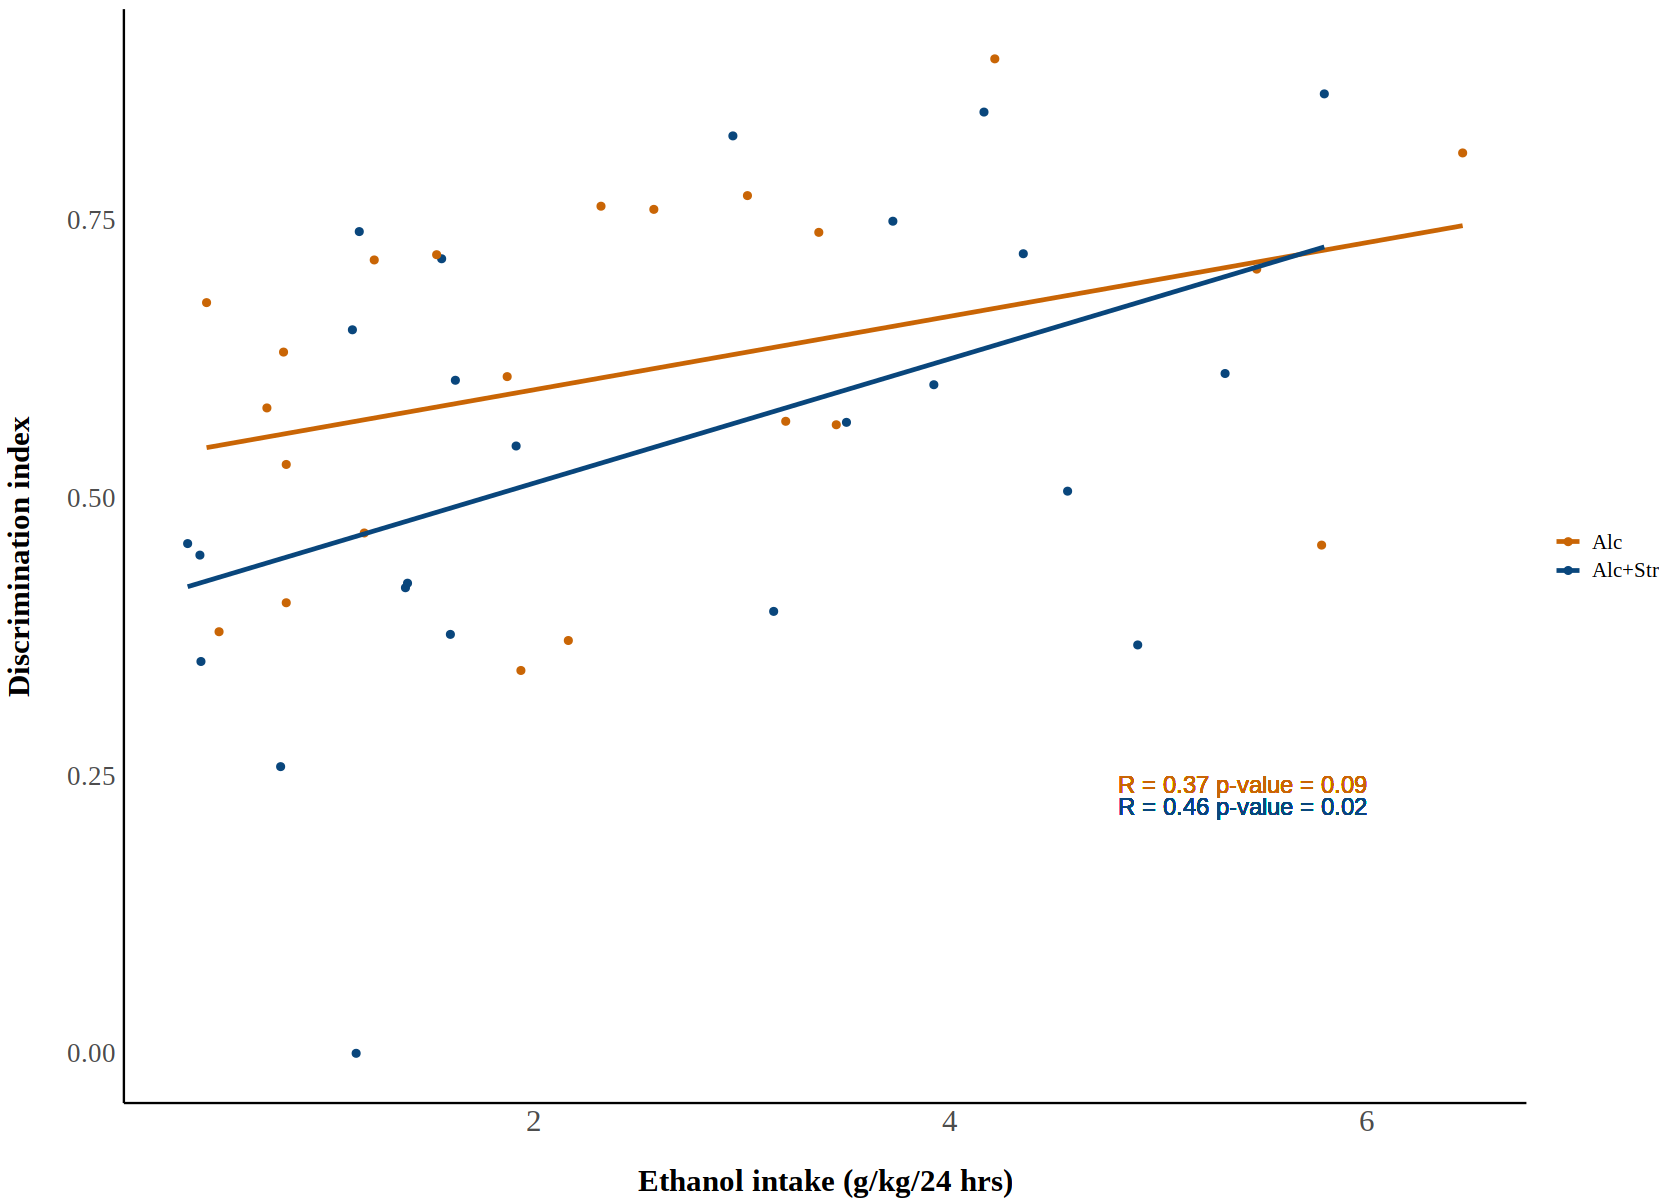

In [87]:
plot_corr_II_AI <- ggplot(filtered_II_AI) +
    geom_point(aes(y = PI, x = main_intake, color = Group)) +
    geom_smooth(aes(y = PI, x = main_intake, color = Group), method = "lm",  se = FALSE) +
    geom_text(aes(x = 6, y = 0.25, 
        label = paste("R =", round(cor_alc_II.AI$estimate, 2), "p-value =", 
            round(cor_alc_II.AI$p.value, 2))), 
              hjust = 1, vjust = 1, color = pal_group[2], size = 5) +
    geom_text(aes(x = 6, y = 0.23, 
        label = paste("R =", round(cor_alcstr_II.AI$estimate, 2), "p-value =", 
            round(cor_alcstr_II.AI$p.value, 2))), 
              hjust = 1, vjust = 1, color = pal_group[4], size = 5) +
    theme_modern() +
    ylab("Discrimination index") +
    xlab("Ethanol intake (g/kg/24 hrs)") +
    scale_color_manual(values = pal_group[c(2,4)]) + theme_settings +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18, face = "bold")) 
plot_corr_II_AI

In [88]:
fem_filtered_nor <- NOR_Report_DLC %>% filter(Sex == "female") %>% 
  mutate(Group = factor(Group, levels = c("Ctrl", "Alc","Str","Alc+Str")))

fem_nose_vars_nor <- grep("nose", names(fem_filtered_nor), value = TRUE) %>% setdiff("nose.total.time")

fem_boxplot_list_nor <- map(fem_nose_vars_nor, ~ ggplot(fem_filtered_nor, aes(x = Group, y = .data[[.]], fill = Group)) +
  xlab("Stage") + ylab("Discrimination ratio") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_boxplot(width = .2) +
  theme_pubr() +
  geom_boxplot() +
  labs(x = "Group", y = .) +
  theme(legend.position = "none") +
  stat_compare_means(comparisons = list(c("Ctrl", "Alc"), c("Ctrl", "Str"), c("Ctrl", "Alc+Str"), 
                                        c("Alc", "Str"), c("Alc", "Alc+Str"), c("Str", "Alc+Str")), 
    method = "t.test", p.adjust.method = "fdr", label="p.format", hide.ns = TRUE)) 
    
male_filtered_nor <- NOR_Report_DLC %>% filter(Sex == "male") %>% 
  mutate(Group = factor(Group, levels = c("Ctrl", "Alc","Str","Alc+Str")))

male_nose_vars_nor <- grep("nose", names(male_filtered_nor), value = TRUE) %>% setdiff("nose.total.time")

male_boxplot_list_nor <- map(male_nose_vars_nor, ~ ggplot(male_filtered_nor, aes(x = Group, y = .data[[.]], fill = Group)) +
  xlab("Stage") + ylab("Anxiety index") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_boxplot(width = .2) +
  theme_pubr() +
  geom_boxplot() +
  labs(x = "Group", y = .) +
  theme(legend.position = "none") +
  stat_compare_means(comparisons = list(c("Ctrl", "Alc"), c("Ctrl", "Str"), c("Ctrl", "Alc+Str"), 
                                        c("Alc", "Str"), c("Alc", "Alc+Str"), c("Str", "Alc+Str")), 
    method = "t.test", p.adjust.method = "fdr", label="p.format", hide.ns = TRUE) )

In [89]:
fem_boxplot_named_nor <- fem_boxplot_list_nor %>% set_names(fem_nose_vars_nor %>% clean_names())
male_boxplot_named_nor <- male_boxplot_list_nor %>% set_names(male_nose_vars_nor %>% clean_names())

fem_nor_plots1_16 <- plot_grid(plotlist = fem_boxplot_named_nor[1:16])
fem_nor_plots17_25 <- plot_grid(plotlist = fem_boxplot_named_nor[17:25])
male_nor_plots1_16 <- plot_grid(plotlist = male_boxplot_named_nor[1:16])
male_nor_plots17_25 <- plot_grid(plotlist = male_boxplot_named_nor[17:25])

## **6. Export data**

In [90]:
dir.create("Figures/NOR")

In [91]:
plot_objects <- ls(pattern = "nor_plots")

walk(plot_objects, ~ggsave(plot = get(.x), dpi=150, height = 15, width = 15, bg="white",
                        filename = paste0("Figures/NOR/", .x, ".png")))

In [92]:
ggsave(plot = plot_NOR, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/NOR/plot_NOR.png")

ggsave(plot = plot_NOR_sex, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/NOR/plot_NOR_sex.png")

In [93]:
save(NOR_Report_DLC,NOR_timeObj,NOR_entries,NOR_II,plot_NOR,plot_NOR_sex, filtered_II_AI,
    file = paste0(getwd(),"/Data/Behavior_metricsNOR.RData"))

---
# **Conditionated place preference**
---

## **2. Data preparation**

Reading files and set it all up.

In [94]:
read_excel_allsheets <- function(filename, tibble = FALSE) {
    sheets <- readxl::excel_sheets(filename)
    x <- lapply(sheets, function(X) readxl::read_excel(filename, sheet = X))
    if(!tibble) x <- lapply(x, as.data.frame)
    names(x) <- sheets
    x
}

In [95]:
CPP_input_folder <- paste0(getwd(),"/Data/Behavior/CPP/")
RID_group <- read_csv("Data/RID_group.csv")
CPP_files <- read_excel_allsheets(paste0(CPP_input_folder,"CPP.xlsx")) %>% reduce(rbind) %>% mutate(RID = case_when(as.numeric(RID) < 10 ~ paste0("sub-00",RID), 
                                  as.numeric(RID) > 10 ~ paste0("sub-0",RID)) )  %>% right_join(RID_group, by = c("RID","Group","Batch")) 

Rows: 96 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): RID, Group, Sex, Batch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [96]:
CPP_files <- read_csv("Data/Behavior/CPP/CPP_metrics.csv")

Rows: 192 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): RID, Group, Sex, Batch, Place, Stage, Time
dbl (1): Time_seg

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## **3. Analysis**

In [97]:
CPP <- CPP_files %>% 
              #filter(Group == "Alc" | Group == "Ctrl" | Group == "Str" | Group == "Alc+Str") %>% 
              mutate(Group = factor(Group, levels = c("Ctrl", "Alc", "Str", "Alc+Str")),
              RID = factor(RID),
              Stage = factor(Stage),
              Place = factor(Place),
              Sex = factor(Sex)) %>% na.omit() %>%
              pivot_wider(names_from = Place, values_from = Time_seg) %>%
              mutate(White = as.numeric(White), Dark = as.numeric(Dark),
                     resta = (White-Dark),
                     suma = (White+Dark),
                     PI = if_else(is.nan(White/suma),0,(White/suma))) %>% na.omit() %>% convert_as_factor(Batch)

In [98]:
CPP_PI <- CPP %>% 
          filter(Time == "Test") 

## **4. Exploratory data analysis**

In [99]:
CPP_PI %>% skimr::skim()

,skim_type,skim_variable,n_missing,complete_rate,character.min,character.max,character.empty,character.n_unique,character.whitespace,factor.ordered,factor.n_unique,factor.top_counts,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<lgl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,character,Time,0,1,4,4,0,1,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,factor,RID,0,1,NA,NA,NA,NA,NA,FALSE,83,"sub: 1, sub: 1, sub: 1, sub: 1",NA,NA,NA,NA,NA,NA,NA,NA
3,factor,Group,0,1,NA,NA,NA,NA,NA,FALSE,4,"Alc: 24, Alc: 23, Ctr: 19, Str: 17",NA,NA,NA,NA,NA,NA,NA,NA
4,factor,Sex,0,1,NA,NA,NA,NA,NA,FALSE,2,"mal: 46, fem: 37",NA,NA,NA,NA,NA,NA,NA,NA
5,factor,Batch,0,1,NA,NA,NA,NA,NA,FALSE,8,"B5: 16, B3: 15, B4: 14, B8: 14",NA,NA,NA,NA,NA,NA,NA,NA
6,factor,Stage,0,1,NA,NA,NA,NA,NA,FALSE,1,T2: 83,NA,NA,NA,NA,NA,NA,NA,NA
7,numeric,Dark,0,1,NA,NA,NA,NA,NA,NA,NA,NA,309.9900000,199.5935457,58.6500000,160.1750000,229.000000,474.4750000,864.8700000,▇▃▃▂▁
8,numeric,White,0,1,NA,NA,NA,NA,NA,NA,NA,NA,337.7395181,218.4315338,57.0200000,147.4250000,315.840000,483.1200000,925.0200000,▇▃▃▁▁
9,numeric,resta,0,1,NA,NA,NA,NA,NA,NA,NA,NA,27.7495181,202.6190566,-431.7300000,-59.5750000,-6.000000,111.3000000,688.0200000,▂▇▃▂▁


── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             83        
Number of columns          11        
_______________________              
Column type frequency:               
  character                1         
  factor                   5         
  numeric                  5         
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 Time                  0             1   4   4     0        1          0

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 RID                   0             1 FALSE         83
2 Group                 0             1 FALSE          4
3 Sex                   0             1 FALSE          2
4

In [100]:
# CPP_extremes <- CPP_PI %>% group_by(Group,Sex) %>% identify_outliers(PI) #%>% filter(is.extreme == TRUE) 
# CPP_PI <- CPP_PI %>% anti_join(CPP_extremes)

### **4.1 Stats (hyphotesis testing)**

In [101]:
CPP.shapiro <-CPP_PI %>% 
    shapiro_test(PI)
CPP.shapiro

CPP.levene <-CPP_PI %>% 
    levene_test(PI~Group)
CPP.levene

variable,statistic,p
<chr>,<dbl>,<dbl>
PI,0.9559394,0.006275118


df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
3,79,1.533958,0.2122139


In [102]:
CPP_PI.aov <- anova_test(data = CPP_PI, dv = PI, wid = RID,
                               between = c(Group,Sex))
CPP_PI.aov

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Group,3,75,0.471,0.703,,0.019
2,Sex,1,75,3.472,0.066,,0.044
3,Group:Sex,3,75,2.426,0.072,,0.088


In [103]:
CPP_PI.t_group <- CPP_PI %>%
  pairwise_t_test(
    PI ~ Group, 
    p.adjust.method = "fdr")
CPP_PI.t_group

,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,PI,Ctrl,Alc,19,24,0.902,ns,0.902,ns
2,PI,Ctrl,Str,19,17,0.470,ns,0.866,ns
3,PI,Alc,Str,24,17,0.379,ns,0.866,ns
4,PI,Ctrl,Alc+Str,19,23,0.721,ns,0.866,ns
5,PI,Alc,Alc+Str,24,23,0.611,ns,0.866,ns
6,PI,Str,Alc+Str,17,23,0.683,ns,0.866,ns


In [104]:
CPP_PI.t_class_sex <- CPP_PI %>%
  group_by(Sex) %>%
  pairwise_t_test(
    PI ~ Group, 
    p.adjust.method = "fdr")
CPP_PI.t_class_sex

,Sex,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,female,PI,Ctrl,Alc,8,10,0.2790,ns,0.418,ns
2,female,PI,Ctrl,Str,8,7,0.8140,ns,0.936,ns
3,female,PI,Alc,Str,10,7,0.2000,ns,0.418,ns
4,female,PI,Ctrl,Alc+Str,8,12,0.2310,ns,0.418,ns
5,female,PI,Alc,Alc+Str,10,12,0.9360,ns,0.936,ns
6,female,PI,Str,Alc+Str,7,12,0.1620,ns,0.418,ns
7,male,PI,Ctrl,Alc,11,14,0.3330,ns,0.466,ns
8,male,PI,Ctrl,Str,11,10,0.3880,ns,0.466,ns
9,male,PI,Alc,Str,14,10,0.9730,ns,0.973,ns


### **4.1 Stats (Linear modelling)**

In [105]:
Model_CPP_PI <- lm(formula = PI ~ Group*Sex+Batch, data = CPP_PI)

In [106]:
emmeans_CPP_PI <- emmeans(Model_CPP_PI, specs = pairwise ~ Group|Sex, adjust="none")
emmeans_CPP_PI$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance()

emmeans_CPP_PI <- emmeans(Model_CPP_PI, specs = pairwise ~ Group|Sex, adjust="fdr")
emmeans_CPP_PI$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance()

contrast,Sex,estimate,SE,df,t.ratio,p.value,p.value.signif
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ctrl - (Alc+Str),male,0.1182003,0.04965159,68,2.380593,0.02009285,*
Alc - (Alc+Str),male,0.1031487,0.05001122,68,2.062511,0.04298181,*


contrast,Sex,estimate,SE,df,t.ratio,p.value,p.value.signif
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>


## **5. Visualization**

In [107]:
CPP.Perc_Group <- CPP_PI %>% group_by(Group) %>% 
            summarise(proportion = (sum(PI > 0.5,na.rm = T)/(sum(PI < 0.5,na.rm = T) + sum(PI > 0.5,na.rm = T))) * 100 )
CPP.Perc_Group_sex <- CPP_PI %>%
            group_by(Group,Sex) %>% 
              summarise(proportion = (sum(PI > 0.5,na.rm = T)/(sum(PI < 0.5,na.rm = T) + sum(PI > 0.5,na.rm = T))) * 100 )


`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


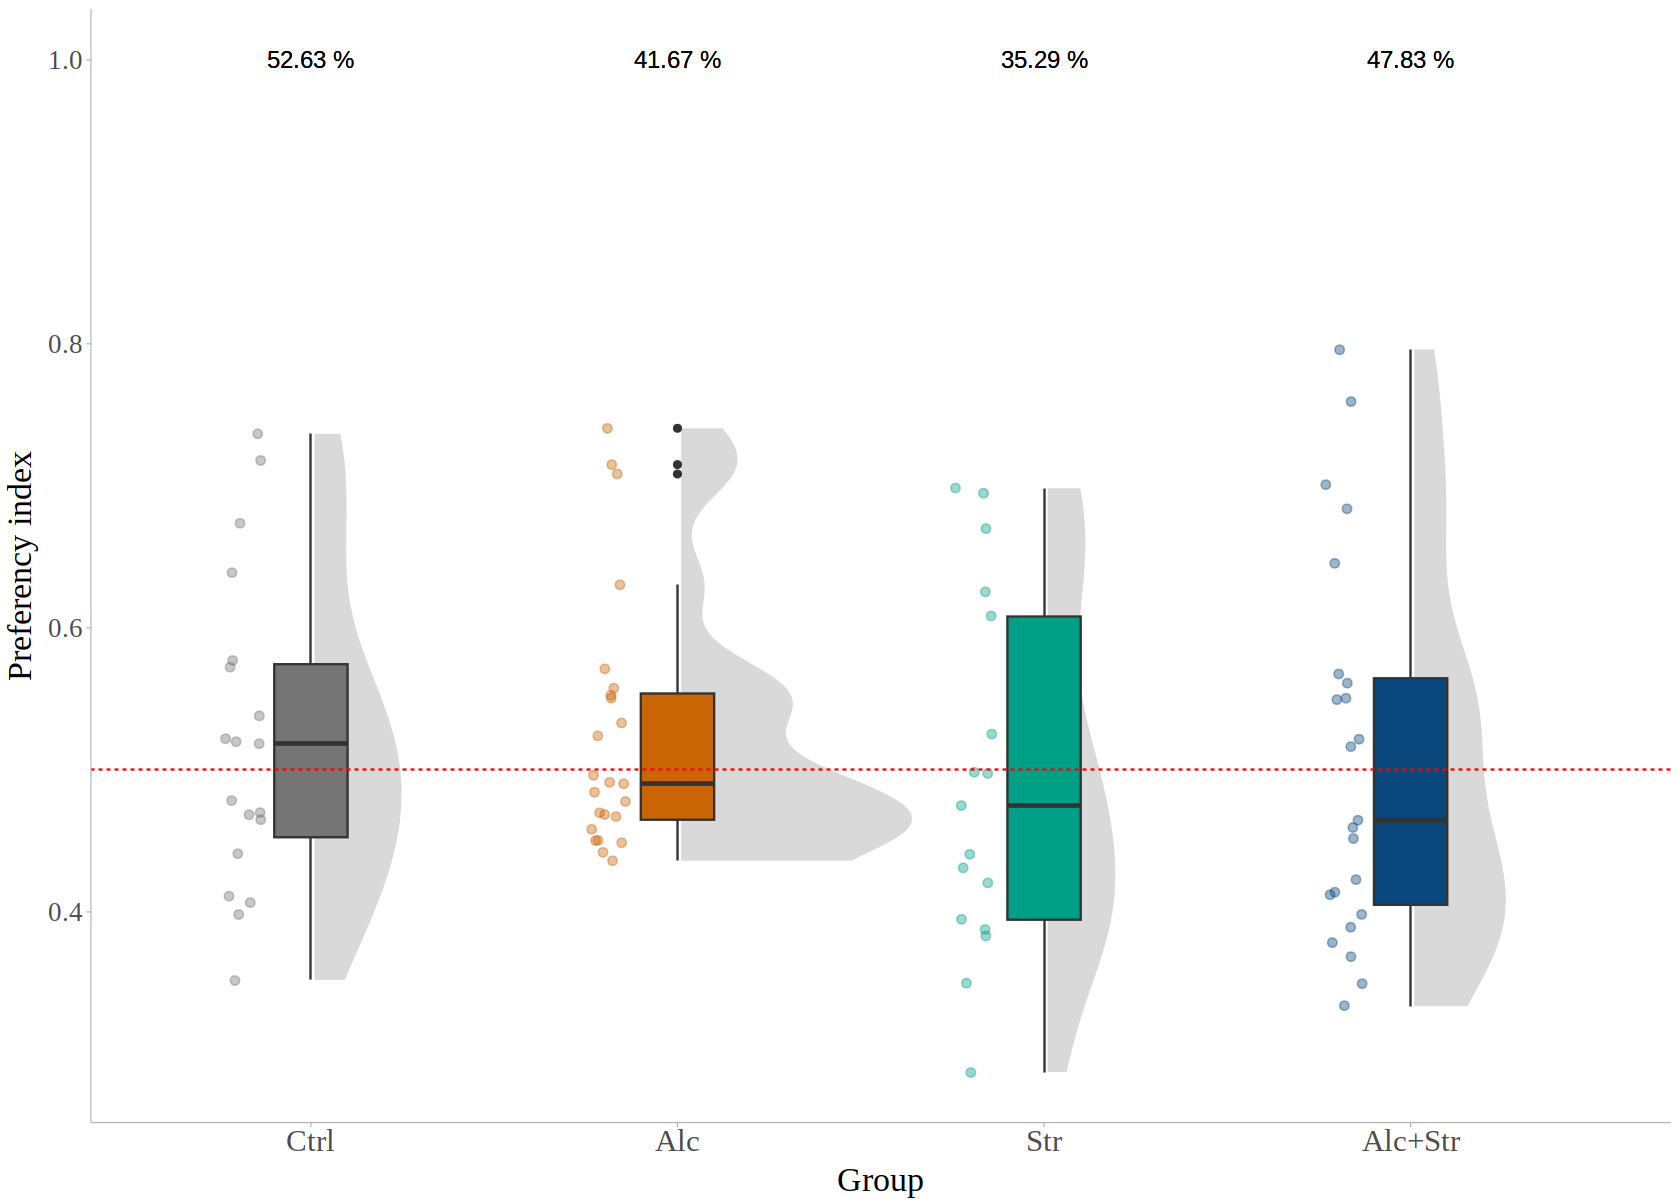

In [108]:
plot_CPP <- CPP_PI %>%
    ggplot(aes(x = Group,y = PI, 
                fill = Group)) + 
    stat_halfeye(
        adjust = .8, width = .7, fill = "grey85",
        interval_colour = NA, 
        position = position_nudge(x = .01),
        aes(thickness = stat(f*n))) +
    gghalves::geom_half_point(aes(color = Group),
                                side = "l", 
                                range_scale = .3, 
                                alpha = .4, size = 2) +
    geom_boxplot(width = .2) + 
    #stat_pvalue_manual(NOR_novel.pwcC,
    #                   tip.length = 0.03, hide.ns = FALSE) +
    #labs(subtitle = get_test_label(NOR_novel.pwcC, 
    #                               detailed = TRUE)) +
    #stat_compare_means(aes(label = after_stat(p.signif)), 
    #                method = "t.test", ref.group = "Ctrl", hide.ns = TRUE) +
    ylab("Preferency index") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
    theme_ggdist() +
    theme(text = element_text(size = 18), legend.position = "none",
            plot.subtitle = element_text(hjust = 1)) + 
    geom_hline(yintercept=0.5, linetype="dashed", color = "red") + 
    theme_settings +
    geom_text(data = data.frame(Group = c(CPP.Perc_Group$Group[1],CPP.Perc_Group$Group[1]),
                                            label = c(paste0(round(CPP.Perc_Group$proportion[1],2)," %"))), 
                aes(x = 1, y = 1, label = label), size = 5) + 
    geom_text(data = data.frame(Group = c(CPP.Perc_Group$Group[2],CPP.Perc_Group$Group[2]),
                                            label = c(paste0(round(CPP.Perc_Group$proportion[2],2)," %"))), 
                aes(x = 2, y = 1, label = label), size = 5) + 
    geom_text(data = data.frame(Group = c(CPP.Perc_Group$Group[3],CPP.Perc_Group$Group[3]),
                                            label = c(paste0(round(CPP.Perc_Group$proportion[3],2)," %"))), 
                aes(x = 3, y = 1, label = label), size = 5) + 
    geom_text(data = data.frame(Group = c(CPP.Perc_Group$Group[4],CPP.Perc_Group$Group[4]),
                                            label = c(paste0(round(CPP.Perc_Group$proportion[4],2)," %"))), 
                aes(x = 4, y = 1, label = label), size = 5)
plot_CPP

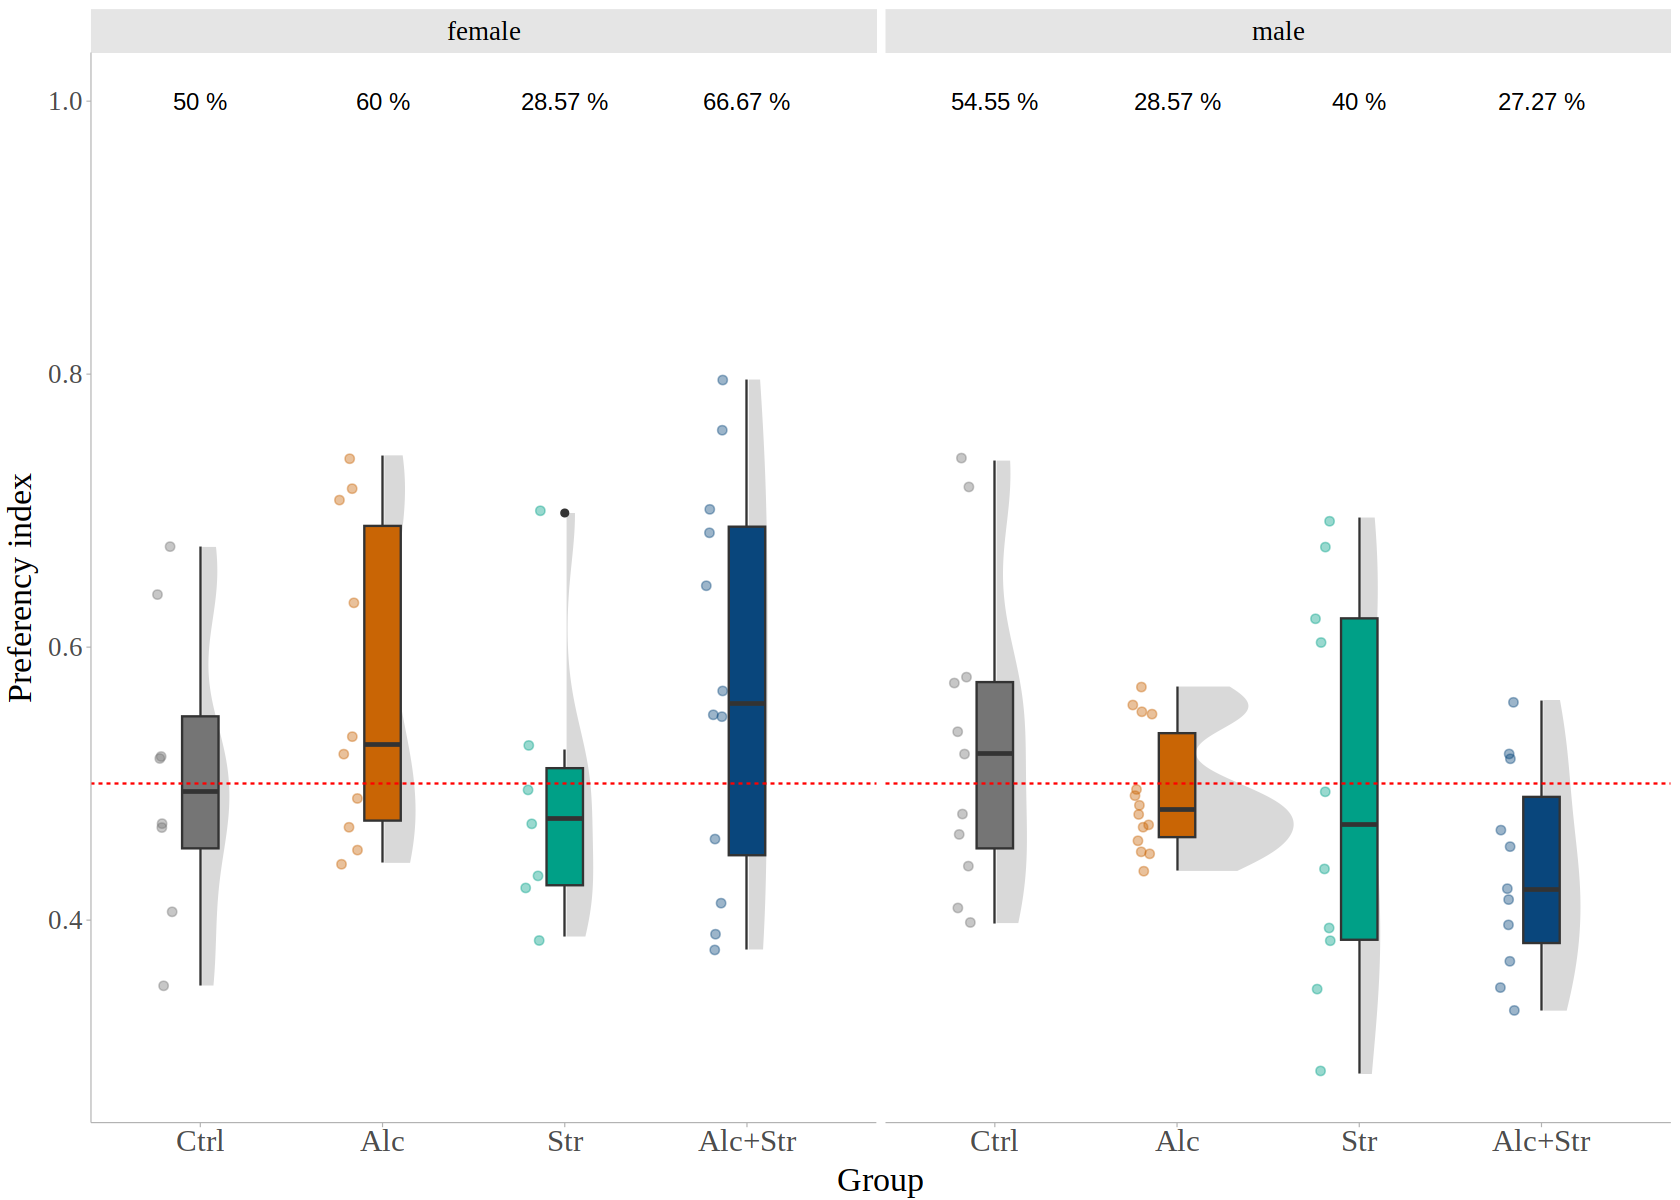

In [109]:
plot_CPP_sex <- CPP_PI %>%
    ggplot(aes(x = Group,y = PI, 
                fill = Group)) + facet_grid(. ~ Sex) +
    stat_halfeye(
        adjust = .8, width = .7, fill = "grey85",
        interval_colour = NA, 
        position = position_nudge(x = .01),
        aes(thickness = stat(f*n))) +
    gghalves::geom_half_point(aes(color = Group),
                                side = "l", 
                                range_scale = .3, 
                                alpha = .4, size = 2) +
    geom_boxplot(width = .2) + 
    #stat_pvalue_manual(NOR_novel.pwcC,
    #                   tip.length = 0.03, hide.ns = FALSE) +
    #labs(subtitle = get_test_label(NOR_novel.pwcC, 
    #                               detailed = TRUE)) +
    #stat_compare_means(aes(label = after_stat(p.signif)), 
    #                method = "t.test", ref.group = "Ctrl", hide.ns = TRUE) +
    ylab("Preferency index") +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) + 
    theme_ggdist() +
    theme(text = element_text(size = 18), legend.position = "none",
            plot.subtitle = element_text(hjust = 1)) + 
    geom_hline(yintercept=0.5, linetype="dashed", color = "red") + 
    theme_settings + 
    geom_text(data = data.frame(Group = c(CPP.Perc_Group_sex$Group[1],CPP.Perc_Group_sex$Group[2]),
                                Sex = c(CPP.Perc_Group_sex$Sex[1],CPP.Perc_Group_sex$Sex[2]), 
                                label = c(paste0(round(CPP.Perc_Group_sex$proportion[1],2)," %"),
                                            paste0(round(CPP.Perc_Group_sex$proportion[2],2)," %"))), 
                aes(x = 1, y = 1, label = label), size = 5) + 
    geom_text(data = data.frame(Group = c(CPP.Perc_Group_sex$Group[3],CPP.Perc_Group_sex$Group[4]),
                                Sex = c(CPP.Perc_Group_sex$Sex[3],CPP.Perc_Group_sex$Sex[4]), 
                                label = c(paste0(round(CPP.Perc_Group_sex$proportion[3],2)," %"),
                                            paste0(round(CPP.Perc_Group_sex$proportion[4],2)," %"))), 
                aes(x = 2, y = 1, label = label), size = 5) + 
    geom_text(data = data.frame(Group = c(CPP.Perc_Group_sex$Group[5],CPP.Perc_Group_sex$Group[6]),
                                Sex = c(CPP.Perc_Group_sex$Sex[5],CPP.Perc_Group_sex$Sex[6]), 
                                label = c(paste0(round(CPP.Perc_Group_sex$proportion[5],2)," %"),
                                            paste0(round(CPP.Perc_Group_sex$proportion[6],2)," %"))), 
                aes(x = 3, y = 1, label = label), size = 5) + 
    geom_text(data = data.frame(Group = c(CPP.Perc_Group_sex$Group[7],CPP.Perc_Group_sex$Group[8]),
                                Sex = c(CPP.Perc_Group_sex$Sex[7],CPP.Perc_Group_sex$Sex[8]), 
                                label = c(paste0(round(CPP.Perc_Group_sex$proportion[7],2)," %"),
                                            paste0(round(CPP.Perc_Group_sex$proportion[8],2)," %"))), 
                aes(x = 4, y = 1, label = label), size = 5)
plot_CPP_sex

## **6. Export data**

In [110]:
dir.create("Figures/CPP")

In [111]:
ggsave(plot = plot_CPP, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/CPP/plot_CPP.png")
ggsave(plot = plot_CPP_sex, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/CPP/plot_CPP_sex.png")

In [112]:
save(CPP_PI,plot_CPP,plot_CPP_sex, file = paste0(getwd(),"/Data/Behavior_metricsCPP.RData"))

# **For PLS**

In [113]:
load(paste0(getwd(),"/Data/Behavior_metricsEPM.RData"))
load(paste0(getwd(),"/Data/Behavior_metricsNOR.RData"))
load(paste0(getwd(),"/Data/Behavior_metricsCPP.RData"))

In [114]:
allNOR_metrics %>% 
    #dplyr::select(RID, Group, Batch, Sex, NOR_names_4pls %>% names()) %>%
    rename_with(~ paste0("NOR_", .), -c(RID, Group, Batch, Sex)) %>% 
    left_join(
    allEPM_metrics %>% #dplyr::select(RID, Group, Batch, Sex, EPM_names_4pls %>% names()) %>% 
    rename_with(~ paste0("EPM_", .), -c(RID, Group, Batch, Sex)) ) %>% 
    mutate(sex_1m = case_when(Sex == "male" ~ 1, Sex == "female" ~ 0), .before = Sex) %>% 
    mutate(across(6:25, ~ ifelse(is.nan(.), 0, .))) %>%
    drop_na() %>% write_csv("Data/Behavior/PLS_preparation/Behavior_metrics4pls.csv")

Joining with `by = join_by(RID, Group, Batch, Sex)`


In [115]:
allNOR_metrics %>%
    #dplyr::select(-contains("percentage"), -contains("raw"), -nose.total.time) %>%
    rename_with(~ paste0("NOR_", .), -c(RID, Group, Batch, Sex)) %>% 
    left_join(
    allEPM_metrics %>%
    #dplyr::select(-contains("percentage"), -contains("raw"), -contains("open"), -contains("closed"), -bodycentre.total.time, nose.dip) %>% 
    rename_with(~ paste0("EPM_", .), -c(RID, Group, Batch, Sex)) ) %>% 
    mutate(sex_1m = case_when(Sex == "male" ~ 1, Sex == "female" ~ 0), .before = Sex) %>%
    mutate_all(~ ifelse(is.nan(.), 0, .)) %>%
    left_join(CPP_PI %>% 
dplyr::select(RID, Dark, White, PI)) # Quedan muchos NA's si unimos CPP
#    drop_na() %>% write_csv("Data/Behavior/PLS_preparation/Behavior_metrics4pls.csv")

Joining with `by = join_by(RID, Group, Batch, Sex)`
Joining with `by = join_by(RID)`


RID,Group,Batch,sex_1m,Sex,NOR_PI,NOR_PI_entries,NOR_Interaction_index,NOR_nose.raw.distance,NOR_nose.distance.moving,⋯,EPM_bodycentre.open.right.raw.speed,EPM_bodycentre.open.right.speed.moving,EPM_bodycentre.open.right.time.moving,EPM_bodycentre.open.right.total.time,EPM_bodycentre.open.right.time.stationary,EPM_bodycentre.open.right.percentage.moving,EPM_bodycentre.open.right.transitions,Dark,White,PI
<chr>,<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sub-013,2,B1,1,male,0.5560345,0.5333333,0.5446839,2346.264,2173.011,⋯,3.502298,9.827165,26.000000,117.20000,91.200000,22.18430,17,212.45,174.03,0.4502950
sub-015,1,B1,1,male,0.7715290,0.6923077,0.7319183,2339.199,2181.845,⋯,5.109619,12.610282,22.000000,90.00000,68.000000,24.44444,20,107.30,124.93,0.5379581
sub-019,2,B2,0,female,0.7388535,0.6666667,0.7027601,2466.675,1586.561,⋯,5.387865,11.450869,17.433333,54.23333,36.800000,32.14505,20,136.43,108.05,0.4419584
sub-020,2,B2,0,female,0.7623824,0.6521739,0.7072782,1877.774,1351.377,⋯,7.196970,11.471392,10.333333,20.66667,10.333333,50.00000,10,NA,NA,NA
sub-021,1,B2,0,female,0.9081967,0.7500000,0.8290984,2094.428,1364.636,⋯,4.611389,12.566412,11.500000,48.73333,37.233333,23.59781,26,132.07,142.77,0.5194659
sub-022,2,B2,0,female,0.7140152,0.5625000,0.6382576,2236.419,1646.072,⋯,7.742794,15.620257,15.633333,36.86667,21.233333,42.40506,14,NA,NA,NA
sub-023,1,B2,0,female,0.5960355,0.5483871,0.5722113,2744.546,2166.440,⋯,6.074203,10.711229,10.766667,27.06667,16.300000,39.77833,10,139.73,150.33,0.5182721
sub-024,2,B2,0,female,0.6090226,0.4705882,0.5398054,3064.954,2038.054,⋯,6.304314,11.324007,21.733333,51.66667,29.933333,42.06452,20,NA,NA,NA
sub-028,1,B2,1,male,0.6070000,0.5517241,0.5793621,2273.738,1775.974,⋯,4.042858,11.075433,16.866667,81.00000,64.133333,20.82305,24,185.10,145.77,0.4405658
